# *deepBreaks* applications
## *deepBreaks* identifies amino acids associated with color sensitivity  
In this study we are trying to use 175 amino-acid sequences to train predictive models for predicting a phenotype which is the the maximum wavelength absobption.  
After that, we use the top 3 models to study their feature importances and merge their results. We cover all three steps of preprocessing, modelling, and interpretaion of the models. Finally we vizualize the results of the models and prioritize the most imposrtant sites of the sequences.  
![alt text](../img/lite_mar/LITE_Mar.png)

In [1]:
# importing deepBreaks libraries 
from deepBreaks.utils import get_models, get_scores, get_params, make_pipeline, df_to_dict,\
imp_print, ref_id_type, report_test_scores, train_test_split
from deepBreaks.preprocessing import MisCare, ConstantCare, URareCare, CustomOneHotEncoder
from deepBreaks.preprocessing import FeatureSelection, CollinearCare, CustomStandardScaler
from deepBreaks.preprocessing import read_data, balanced_classes
from deepBreaks.models import model_compare_cv, finalize_top, importance_from_pipe, mean_importance, summarize_results
from deepBreaks.visualization import plot_scatter, dp_plot, plot_imp_model, plot_imp_all, visualize_reg, visualize_cl
import warnings
import datetime
import os

In [2]:
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [3]:
# defining user params, file pathes, analysis type

# path to sequences
seqFileName = '/Users/mbagh/Documents/RahLab/deepBreaks_data/lite_mar/msa_RodOpsinLambdaMax.fasta' 

# path to metadata
metaDataFileName = '/Users/mbagh/Documents/RahLab/deepBreaks_data/lite_mar/meta_RodOpsinLambdaMax.tsv' 

# name of the phenotype
mt = 'LambdaMax'

# type of the sequences
seq_type = 'aa'

# type of the analysis if it is a classification model, then we put cl instead of reg
ana_type = 'reg' 
seed = 123

In [4]:
# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('.')[0]
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [5]:
%%time
print('reading meta-data')
# importing metadata
meta_data = read_data(metaDataFileName, seq_type = None, is_main=False)

# importing sequences data
print('reading fasta file')
tr = read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold=0.7)

# sequence data in dictionary format
raw_seq = df_to_dict(tr)
print('Shape of data is: ', tr.shape)


tr = tr.merge(meta_data.loc[:, mt],  left_index=True, right_index=True)
y = tr.loc[:, mt].values
tr.drop(mt, axis=1, inplace=True)
print('Shape of data is: ', tr.shape)

reading meta-data
reading fasta file
Columns with missing values over the gap_threshold% will be dropped and eliminate from the analysis during preprocessing.Please use the missing_constant_care function to take care of missing values.
Shape of data is:  (175, 356)
Shape of data is:  (175, 356)
CPU times: user 65.6 ms, sys: 5.76 ms, total: 71.3 ms
Wall time: 73.6 ms


**Attention**: metadata and sequences data should have the names as their row names and for each sequence their must be a value in the meta data file.

In [6]:
print('metadata looks like this:')
meta_data.head()

metadata looks like this:


Species  LambdaMax
1_KC250344.1_Acipenser_transmontanus  Acipenser_transmontanus      540.0
2_AF137208.1_Amia_calva                            Amia_calva      527.0
3_HQ444181.1_Gymnothorax_favagineus    Gymnothorax_favagineus      488.0
4_HQ444182.1_Gymnothorax_reticularis  Gymnothorax_reticularis      486.0
5_HQ444180.1_Rhinomuraena_quaesita      Rhinomuraena_quaesita      498.0

In [7]:
print('sequence data looks like this:')
tr.head()

sequence data looks like this:


p1 p2 p3 p4 p5 p6 p7 p8 p9 p10  ... p347  \
1_KC250344.1_Acipenser_transmontanus  N  N  N  N  N  N  N  N  N   N  ...    N   
2_AF137208.1_Amia_calva               N  N  N  N  N  N  N  N  N   N  ...    N   
3_HQ444181.1_Gymnothorax_favagineus   N  N  N  N  N  N  N  N  N   N  ...    N   
4_HQ444182.1_Gymnothorax_reticularis  N  N  N  N  N  N  N  N  N   N  ...    N   
5_HQ444180.1_Rhinomuraena_quaesita    N  N  N  N  N  N  N  N  N   N  ...    N   

                                     p348 p349 p350 p351 p352 p353 p354 p355  \
1_KC250344.1_Acipenser_transmontanus    N    N    N    N    N    N    N    N   
2_AF137208.1_Amia_calva                 N    N    N    N    N    N    N    N   
3_HQ444181.1_Gymnothorax_favagineus     N    N    N    N    N    N    N    N   
4_HQ444182.1_Gymnothorax_reticularis    N    N    N    N    N    N    N    N   
5_HQ444180.1_Rhinomuraena_quaesita      N    N    N    N    N    N    N    N   

                                     p356  
1_KC250344.1_Acipenser_transmontanus    N  
2_AF137208.1_Amia_calva                 N  
3_HQ444181.1_Gymnothorax_favagineus     N  
4_HQ444182.1_Gymnothorax_reticularis    N  
5_HQ444180.1_Rhinomuraena_quaesita      N  

[5 rows x 356 columns]

### Preprocessing
In this step, we do all these steps:
1. dropping columns with a number of missing values above a certain threshold  
2. dropping zero entropy columns  
3. imputing missing values with the mode of that column  
4. replacing cases with a frequency below a threshold (default 1.5%) with the mode of that column
5. dropping zero entropy columns
6. use statistical tests (each position against the phenotype) and drop columns with p-values below a threshold (default 0.25)
7. one-hot encode the remaining columns
8. calculate the pair-wise distance matrix for all of the columns
9. use the distance matrix for DBSCAN and cluster the correlated positions together
10. keep only one column (closes to center of each cluster) for each group and drop the rest from the training data set

In [8]:
prep_pipeline = make_pipeline(
    steps=[
        ('mc', MisCare(missing_threshold=0.05)),
        ('cc', ConstantCare()),
        ('ur', URareCare(threshold=0.025)),
        ('cc2', ConstantCare()),
        ('one_hot', CustomOneHotEncoder()),
        ('st_sc', CustomStandardScaler()),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.25, keep=False)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.25, keep=False))
    ])

In [9]:
%%time
report, top = model_compare_cv(X=tr, y=y, preprocess_pipe=prep_pipeline,
                               models_dict=get_models(ana_type=ana_type),
                               scoring=get_scores(ana_type=ana_type),
                               report_dir=report_dir,
                               cv=10, ana_type=ana_type, cache_dir=None)

Fitting rf...
Fitting Adaboost...
Fitting et...
Fitting gbc...
Fitting dt...
Fitting lr...
Fitting Lasso...
Fitting LassoLars...
Fitting BayesianRidge...
Fitting HubR...
Fitting lgbm...
Fitting xgb...
CPU times: user 2.85 s, sys: 2.05 s, total: 4.9 s
Wall time: 25.4 s


In [10]:
report

R2       MAE        MSE      RMSE      MAPE
rf             0.539731  4.407210  46.096161  6.324157  0.008768
Lasso          0.508348  4.701397  55.418831  6.876778  0.009334
LassoLars      0.508337  4.701447  55.419661  6.876842  0.009334
xgb            0.462976  4.674579  52.744389  6.736352  0.009289
gbc            0.448243  4.485582  50.255654  6.661890  0.008924
Adaboost       0.442539  5.068726  62.285812  7.260129  0.010086
BayesianRidge  0.350313  4.655014  55.261202  7.087823  0.009255
dt             0.321901  5.083900  70.361922  7.766844  0.010089
et             0.297773  4.961207  69.215706  7.725786  0.009850
lgbm           0.268544  5.549810  72.948224  8.061616  0.010992
lr            -0.213200  5.481471  85.813615  8.858530  0.010917
HubR          -0.322260  5.413606  86.464902  8.942203  0.010797

In [11]:
prep_pipeline = make_pipeline(
    steps=[
        ('mc', MisCare(missing_threshold=0.05)),
        ('cc', ConstantCare()),
        ('ur', URareCare(threshold=0.025)),
        ('cc2', ConstantCare()),
        ('one_hot', CustomOneHotEncoder()),
        ('st_sc', CustomStandardScaler()),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.25, keep=True)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.25, keep=True))
        ])

In [12]:
modified_top = []
for model in top:
    modified_top.append(make_pipeline(steps=[('prep', prep_pipeline), model.steps[-1]]))

In [13]:
modified_top[0]

Pipeline(steps=[('prep',
                 Pipeline(steps=[('mc', MisCare(missing_threshold=0.05)),
                                 ('cc', ConstantCare()),
                                 ('ur', URareCare(threshold=0.025)),
                                 ('cc2', ConstantCare()),
                                 ('one_hot', CustomOneHotEncoder()),
                                 ('st_sc', CustomStandardScaler()),
                                 ('feature_selection',
                                  FeatureSelection(alpha=0.25, keep=True,
                                                   model_type='reg')),
                                 ('collinear_care',
                                  CollinearCare(dist_method='correlation',
                                                keep=True, threshold=0.25))])),
                ('rf', RandomForestRegressor(n_jobs=-1, random_state=123))])

In [14]:
%%time
top = finalize_top(X=tr, y=y, top_models=modified_top, grid_param=get_params(),report_dir=report_dir, cv=10)

Tuning rf...
Tuning Lasso...


/Users/mbagh/opt/anaconda3/envs/deepBreaks_113/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.163e+01, tolerance: 2.017e+00
  model = cd_fast.enet_coordinate_descent(


Tuning LassoLars...
CPU times: user 3.11 s, sys: 1.86 s, total: 4.97 s
Wall time: 21.1 s


In [15]:
top[0]

Pipeline(steps=[('prep',
                 Pipeline(steps=[('mc', MisCare(missing_threshold=0.05)),
                                 ('cc', ConstantCare()),
                                 ('ur', URareCare(threshold=0.025)),
                                 ('cc2', ConstantCare()),
                                 ('one_hot', CustomOneHotEncoder()),
                                 ('st_sc', CustomStandardScaler()),
                                 ('feature_selection',
                                  FeatureSelection(alpha=0.25, keep=True,
                                                   model_type='reg')),
                                 ('collinear_care',
                                  CollinearCare(dist_method='correlation',
                                                keep=True, threshold=0.25))])),
                ('rf',
                 RandomForestRegressor(max_features='sqrt', n_jobs=-1,
                                       random_state=123))])

In [16]:
%%time
sr = summarize_results(top_models=top, report_dir=report_dir)

CPU times: user 80.2 ms, sys: 187 ms, total: 267 ms
Wall time: 53.7 ms


In [17]:
sr.head()

feature   p_value     score   rf  Lasso  LassoLars  mean
0    p1_N  0.582523  0.303314  0.0    0.0        0.0   0.0
1    p3_N  0.582523  0.303314  0.0    0.0        0.0   0.0
2    p4_T  0.124991  2.376617  0.0    0.0        0.0   0.0
3    p5_N  0.124991  2.376617  0.0    0.0        0.0   0.0
4    p6_N  0.124991  2.376617  0.0    0.0        0.0   0.0

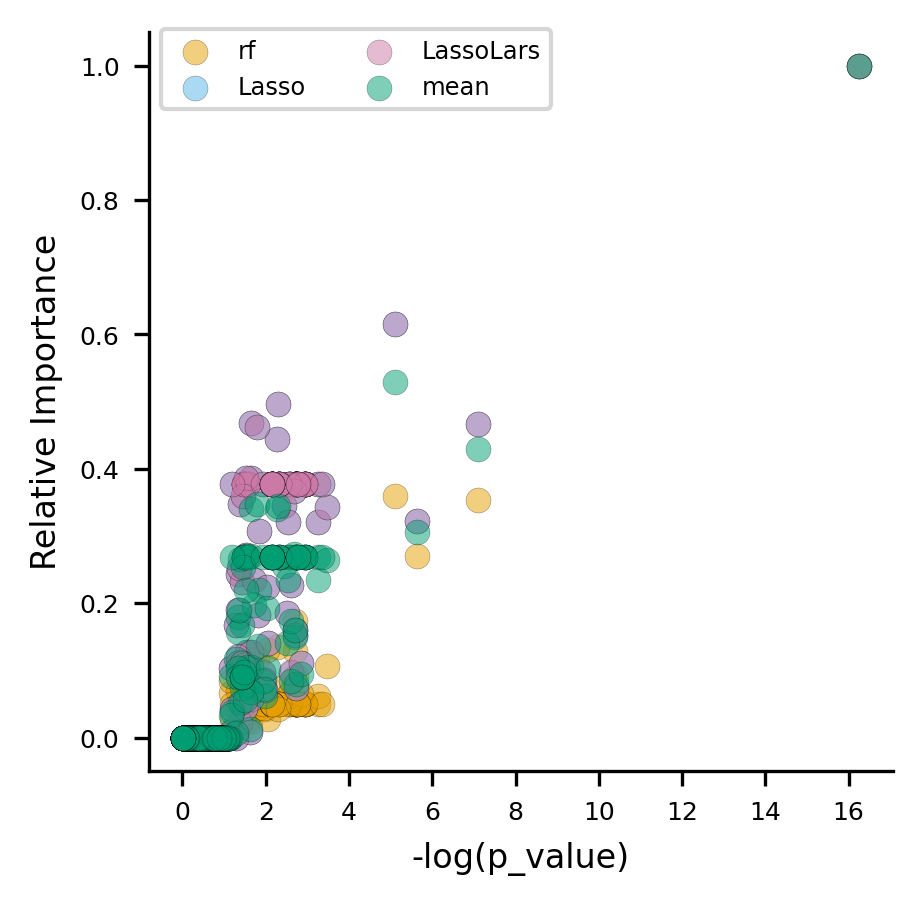

In [18]:
scatter_plot = plot_scatter(summary_result=sr, report_dir=report_dir)

In [19]:
%%time
mean_imp = mean_importance(top, report_dir=report_dir)

CPU times: user 80.8 ms, sys: 20.3 ms, total: 101 ms
Wall time: 39.5 ms


mean Done


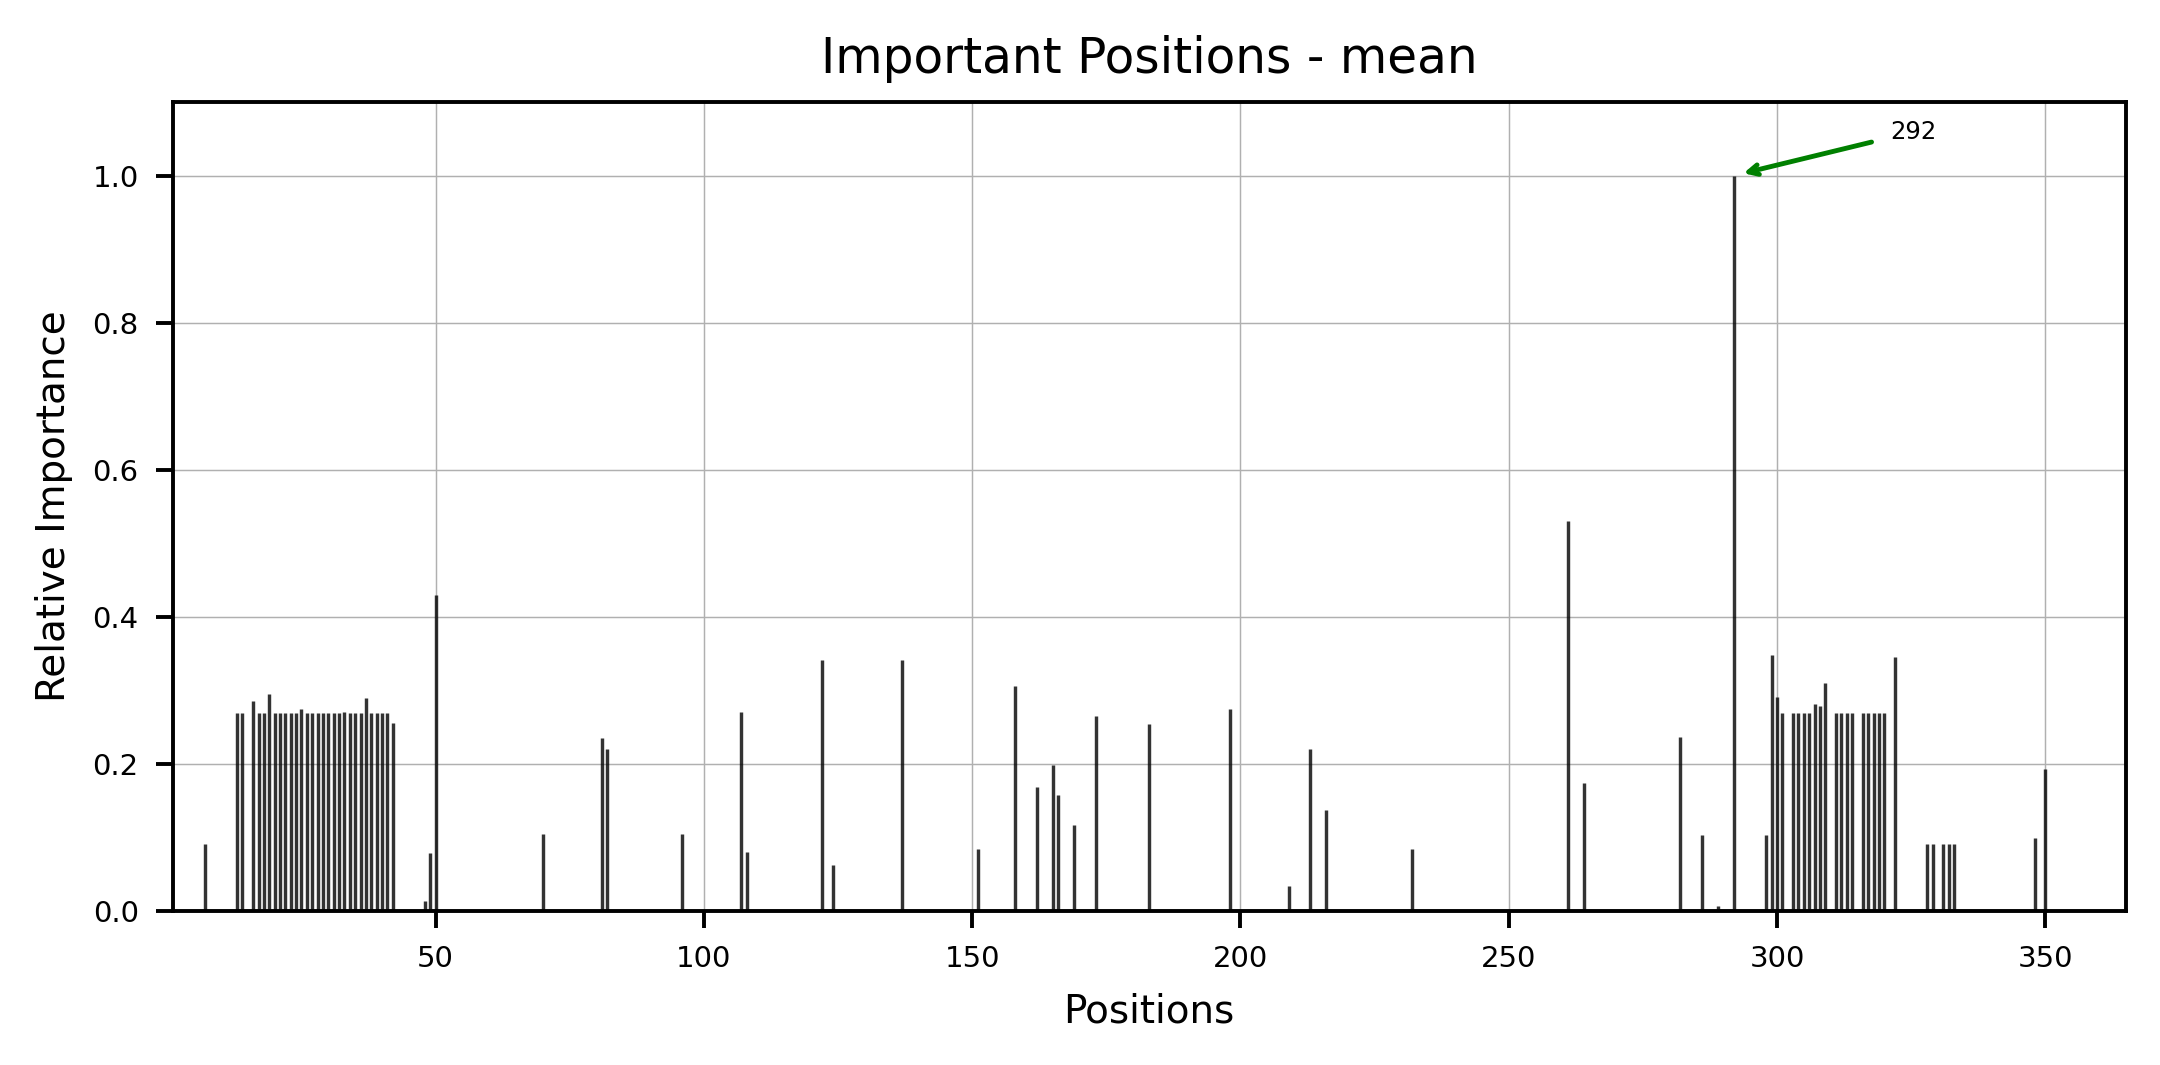

In [20]:
dp_plot(importance=mean_imp,imp_col='mean', model_name='mean', report_dir=report_dir)

In [21]:
tr = prep_pipeline[:4].fit_transform(tr)

rf Done
rf  Done
Lasso Done
Lasso  Done
LassoLars Done
LassoLars  Done


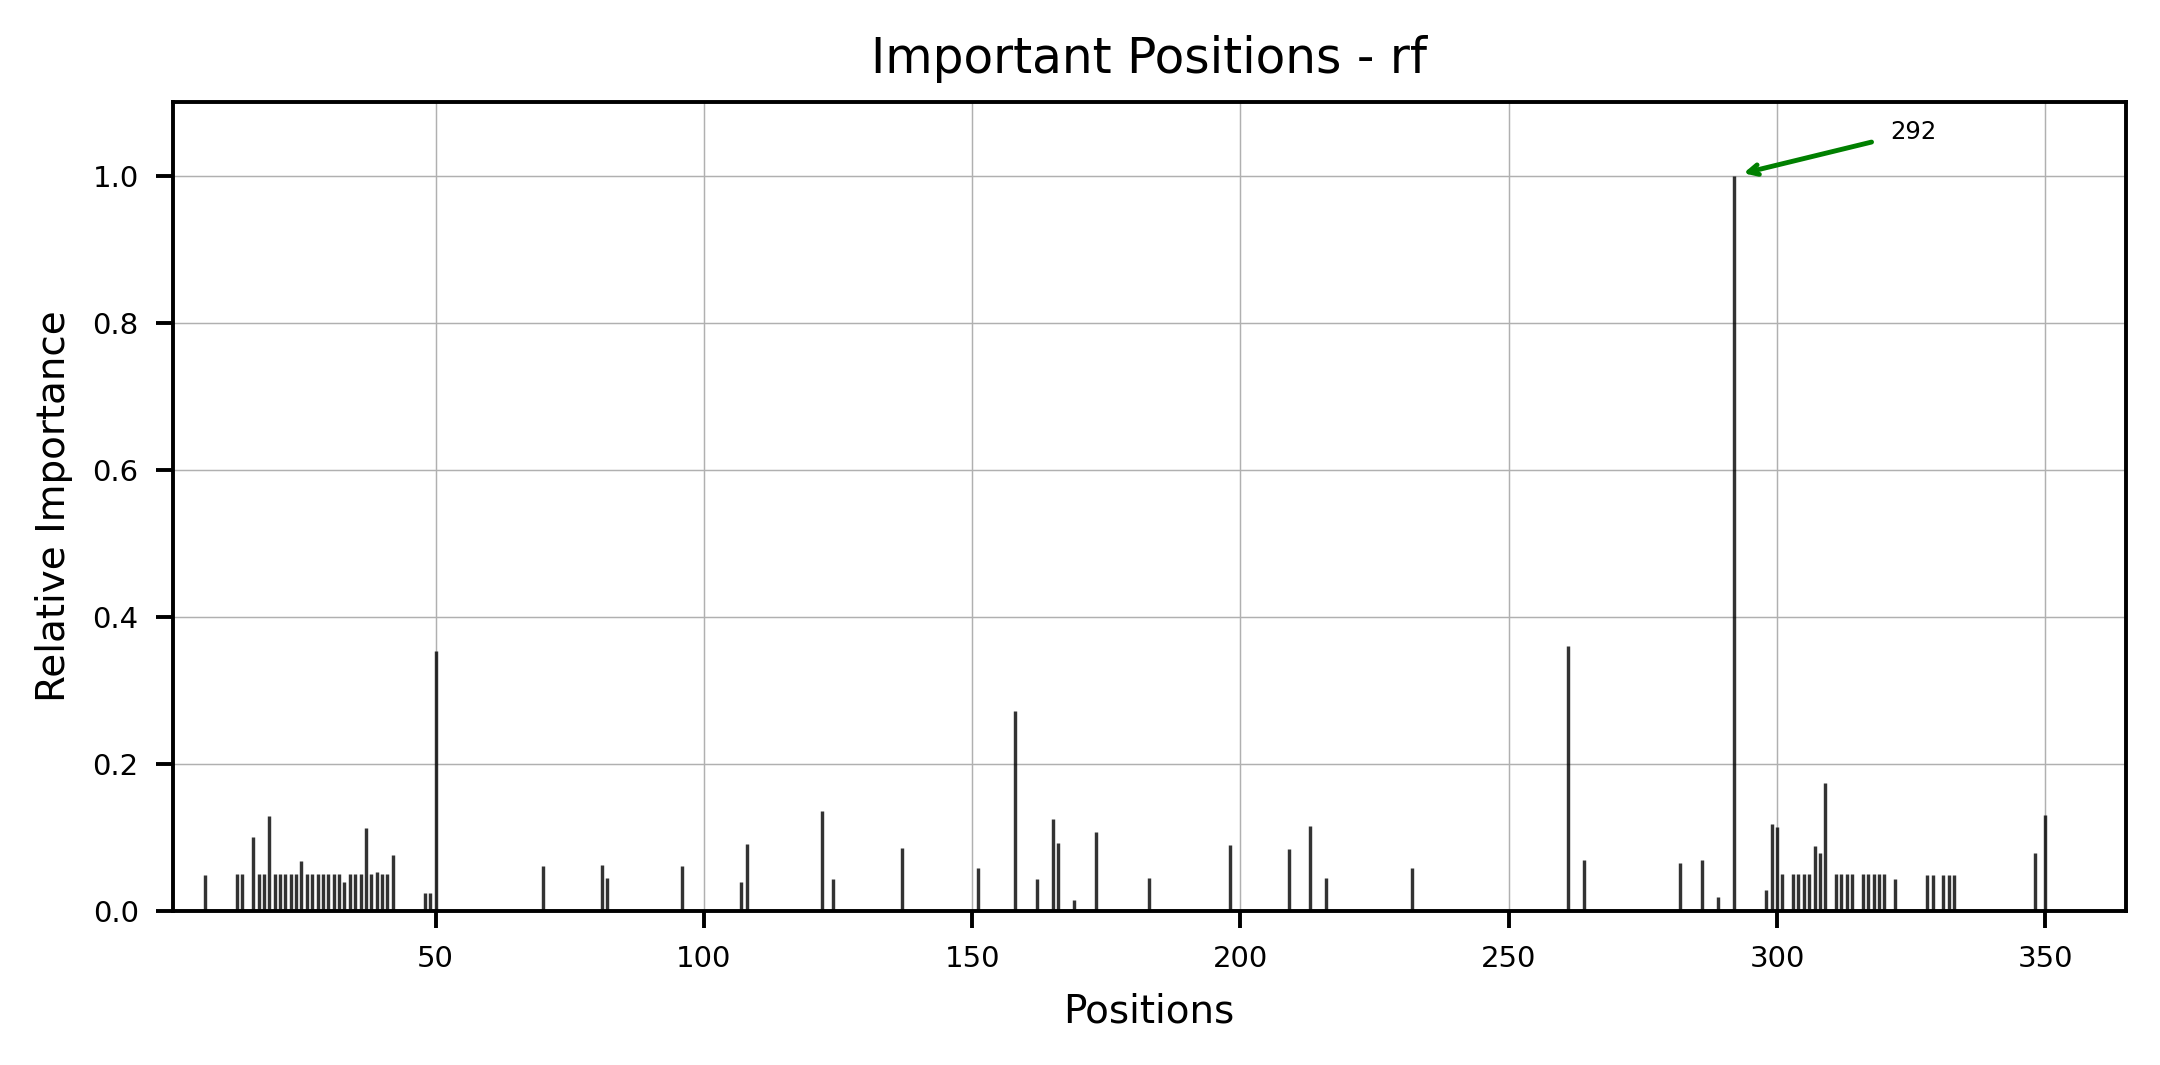

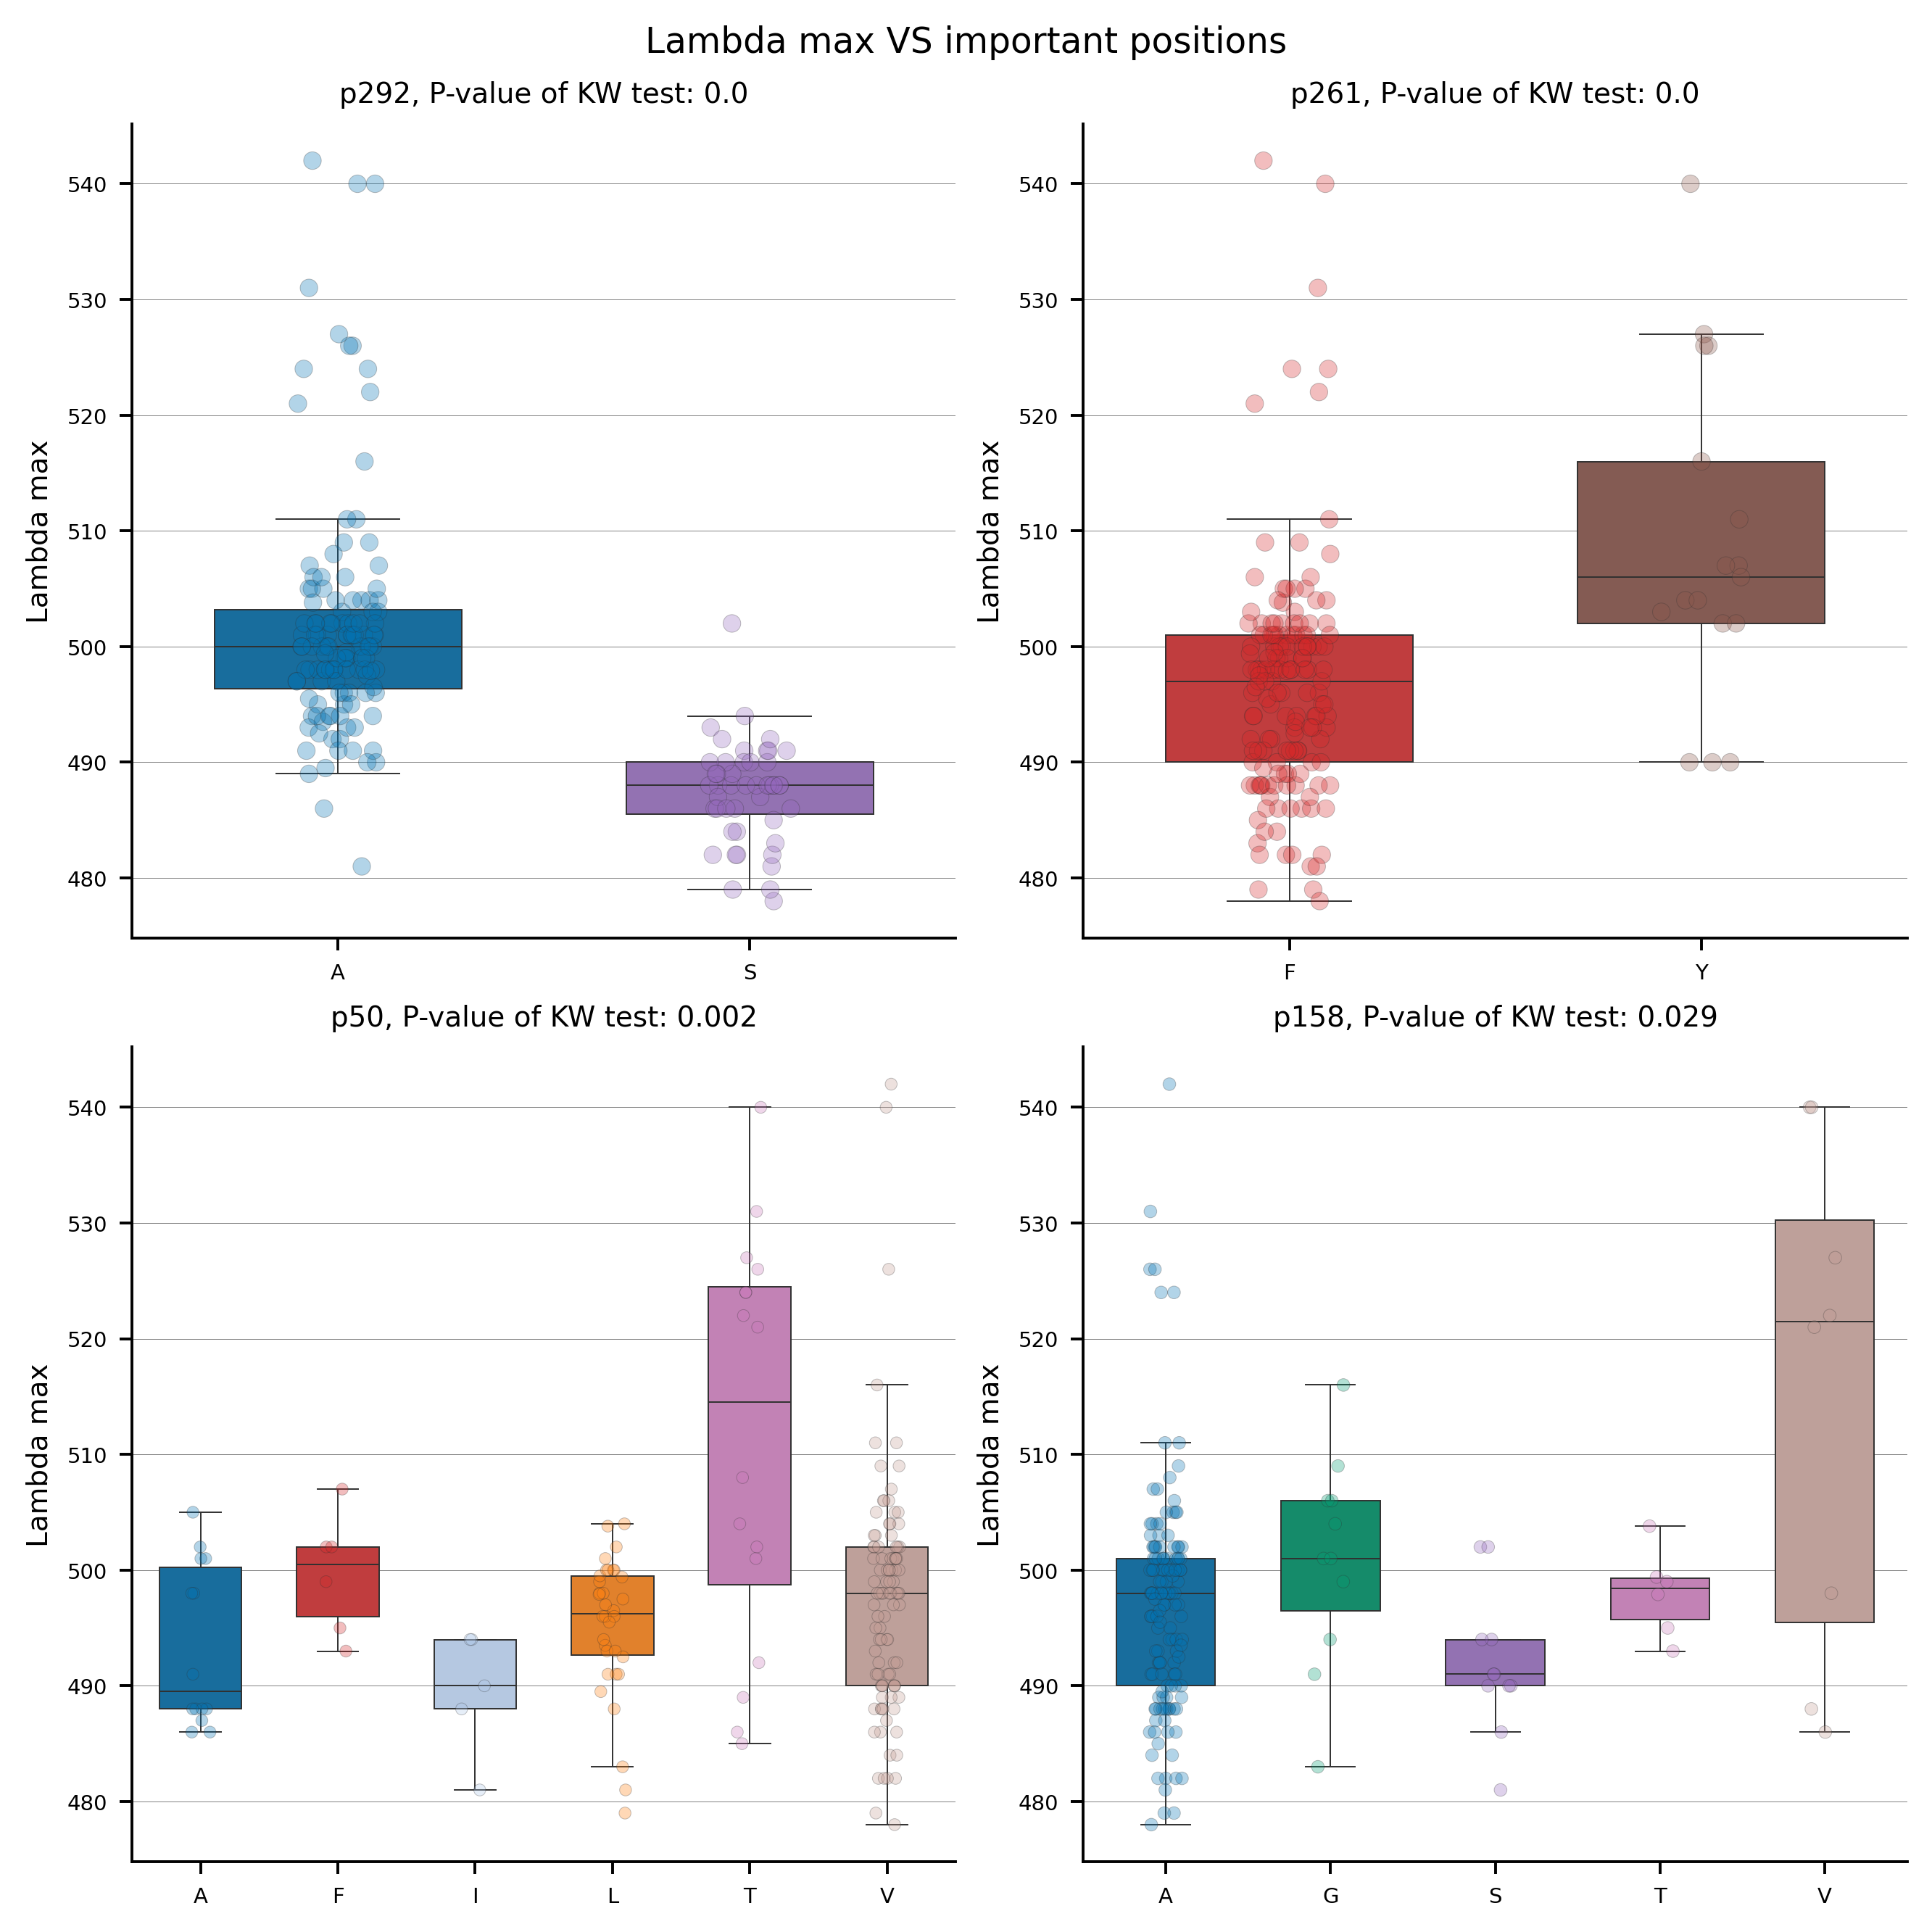

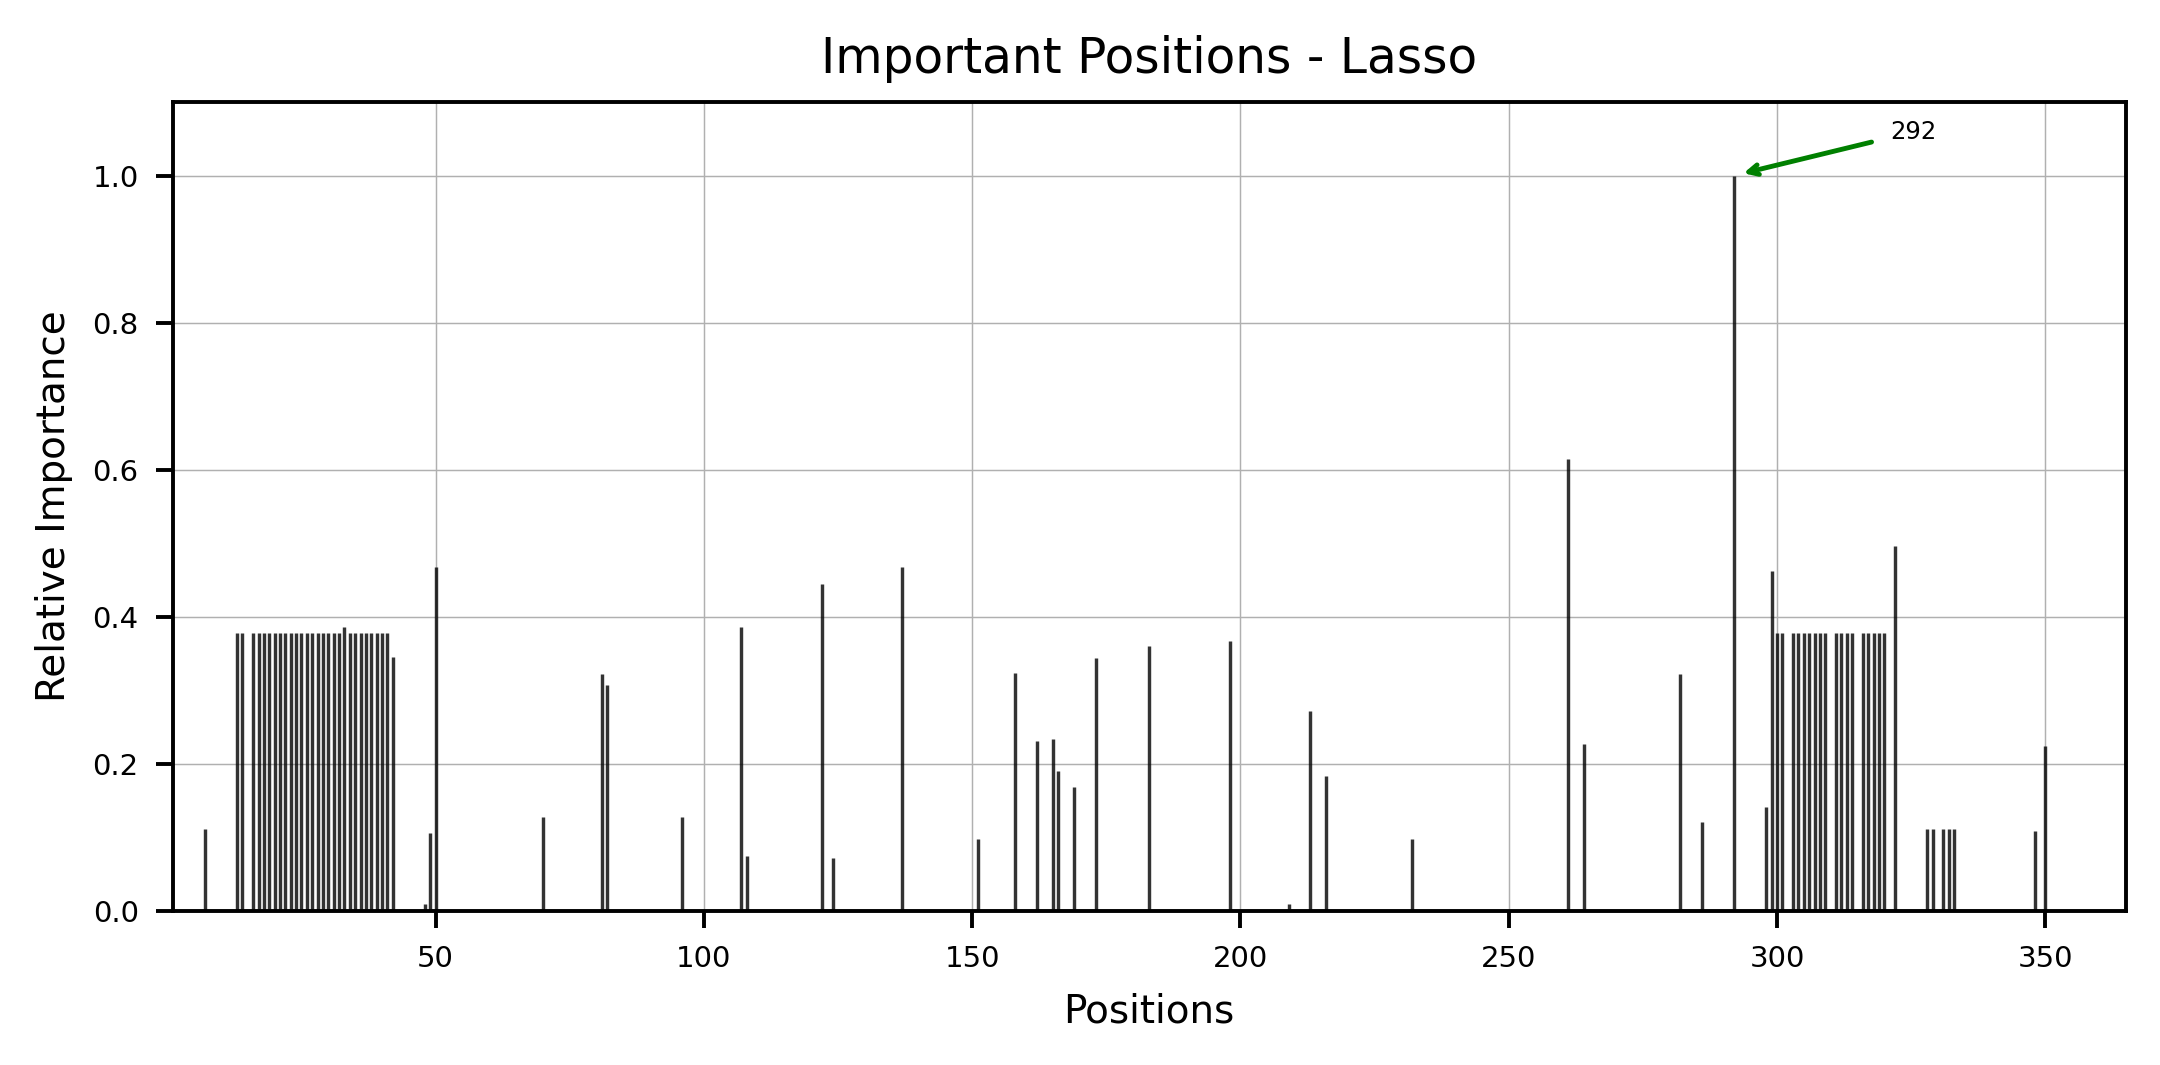

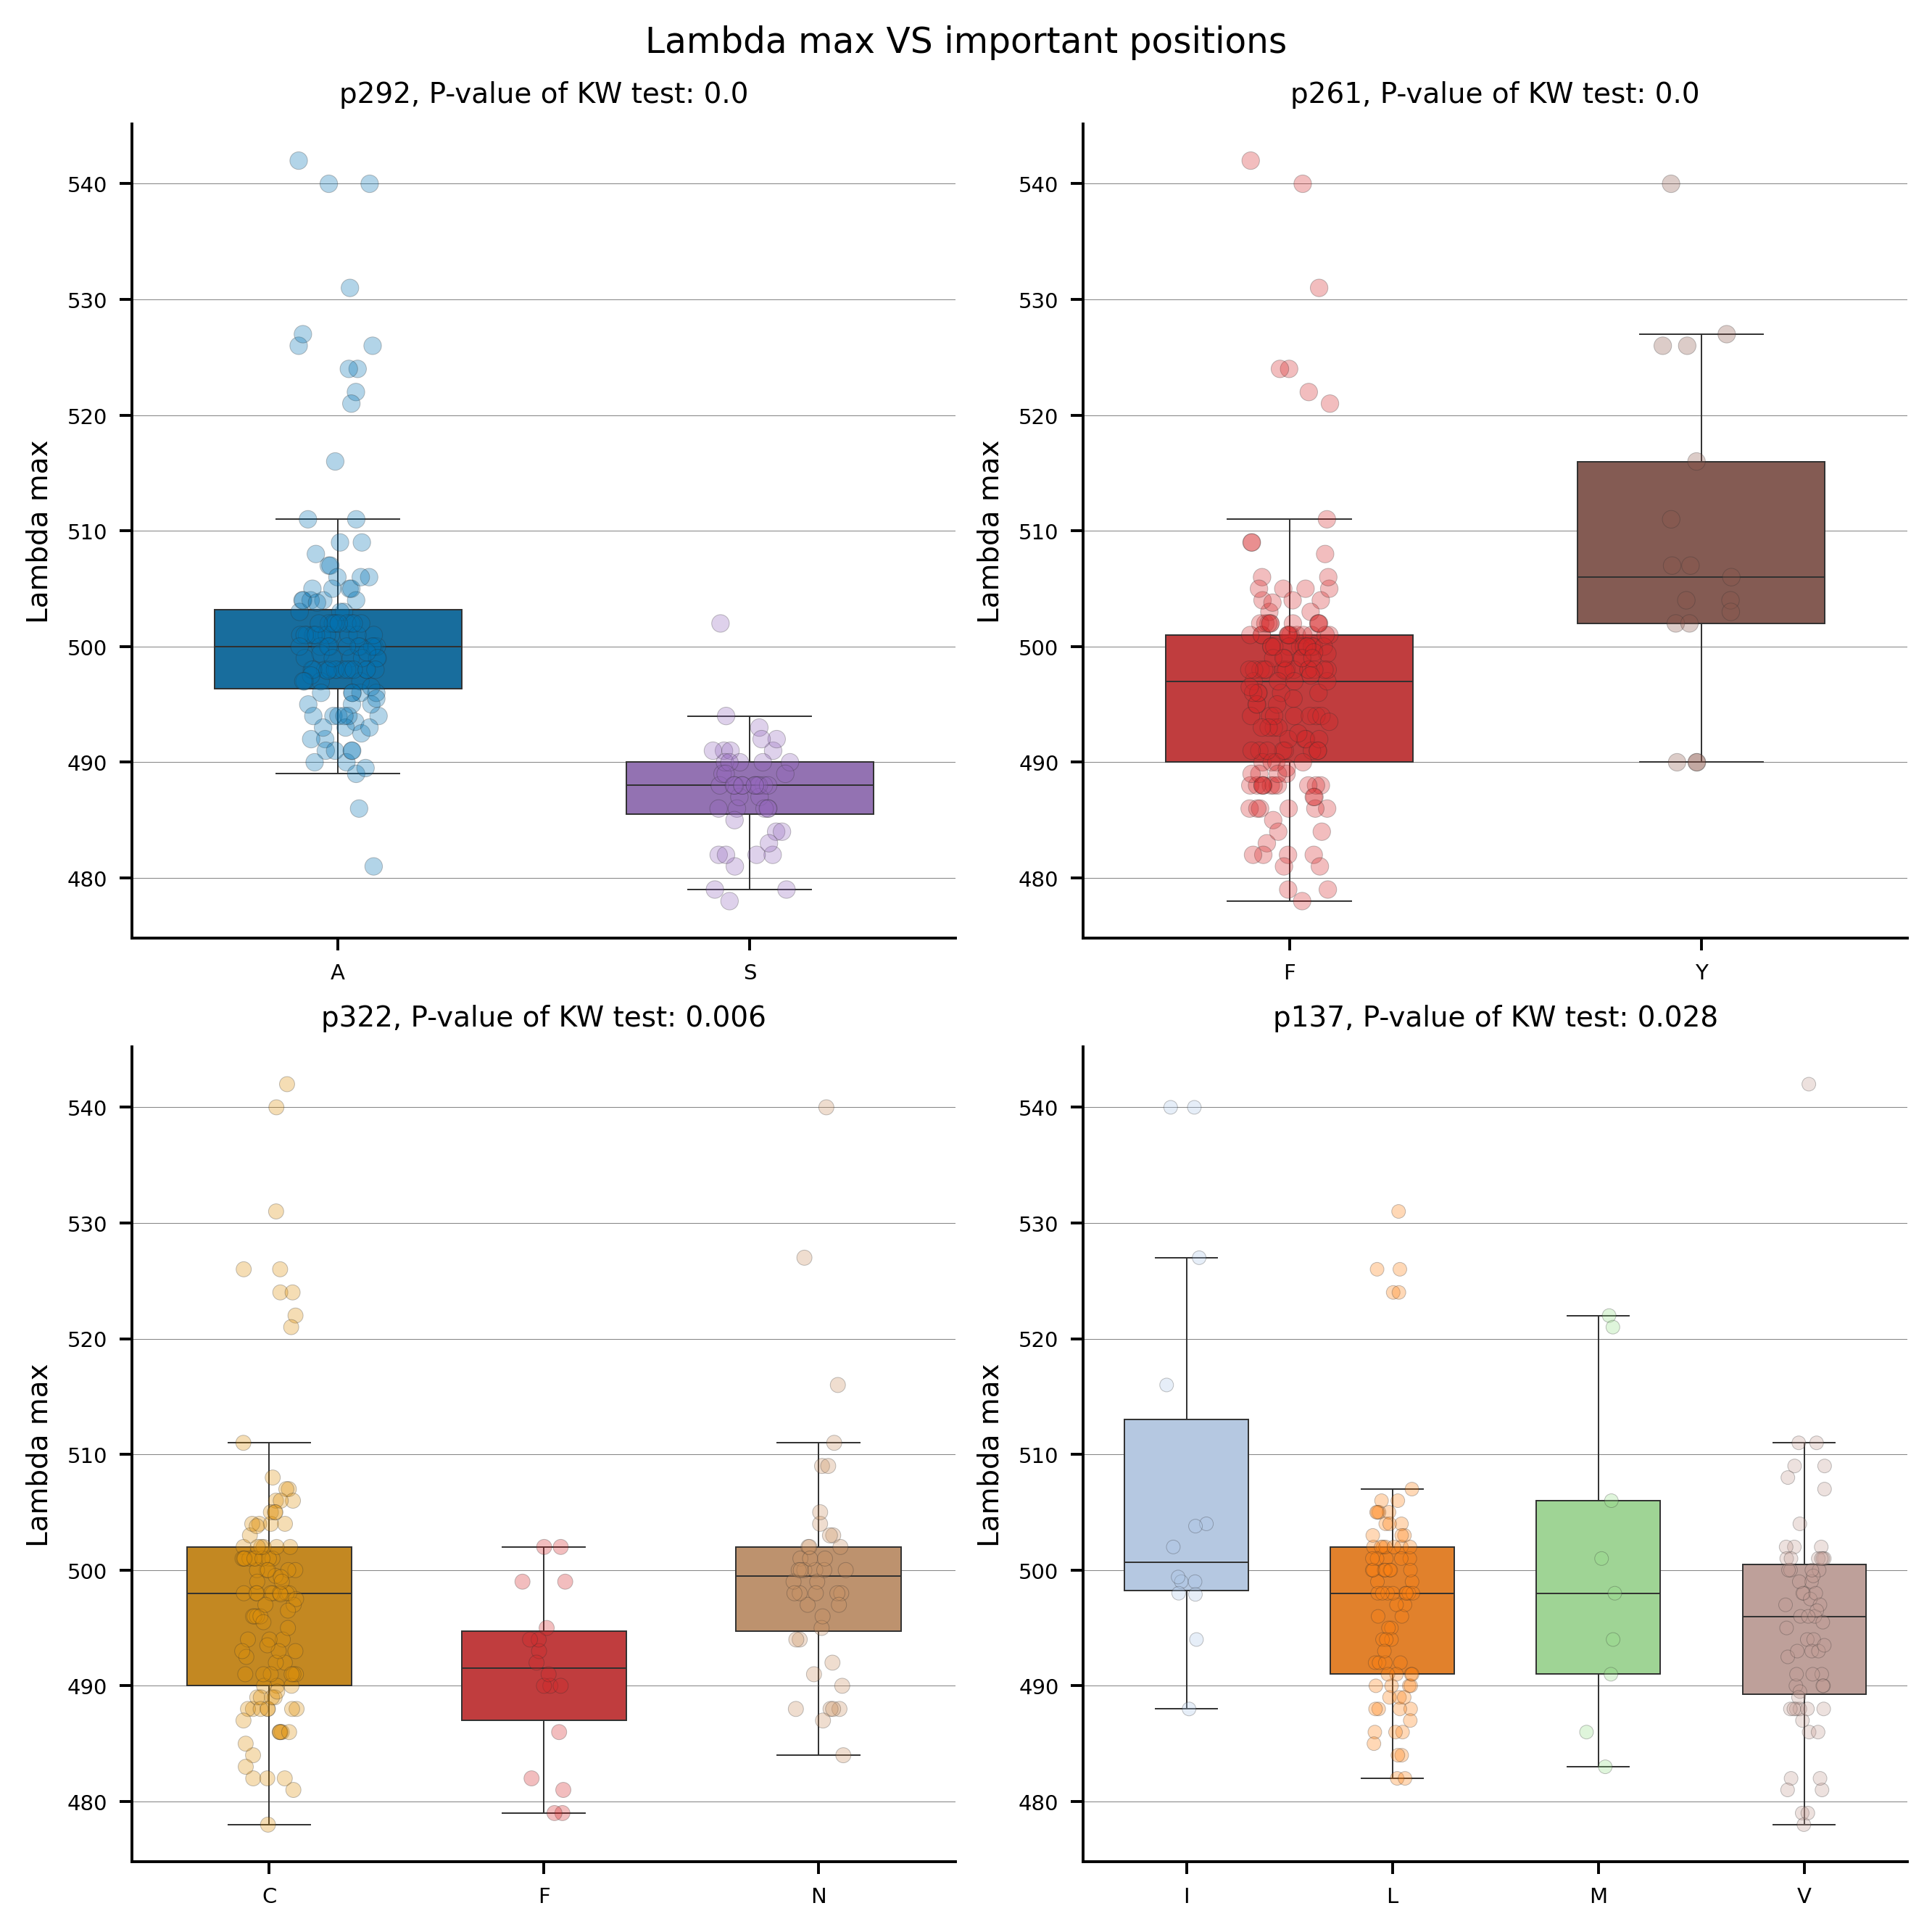

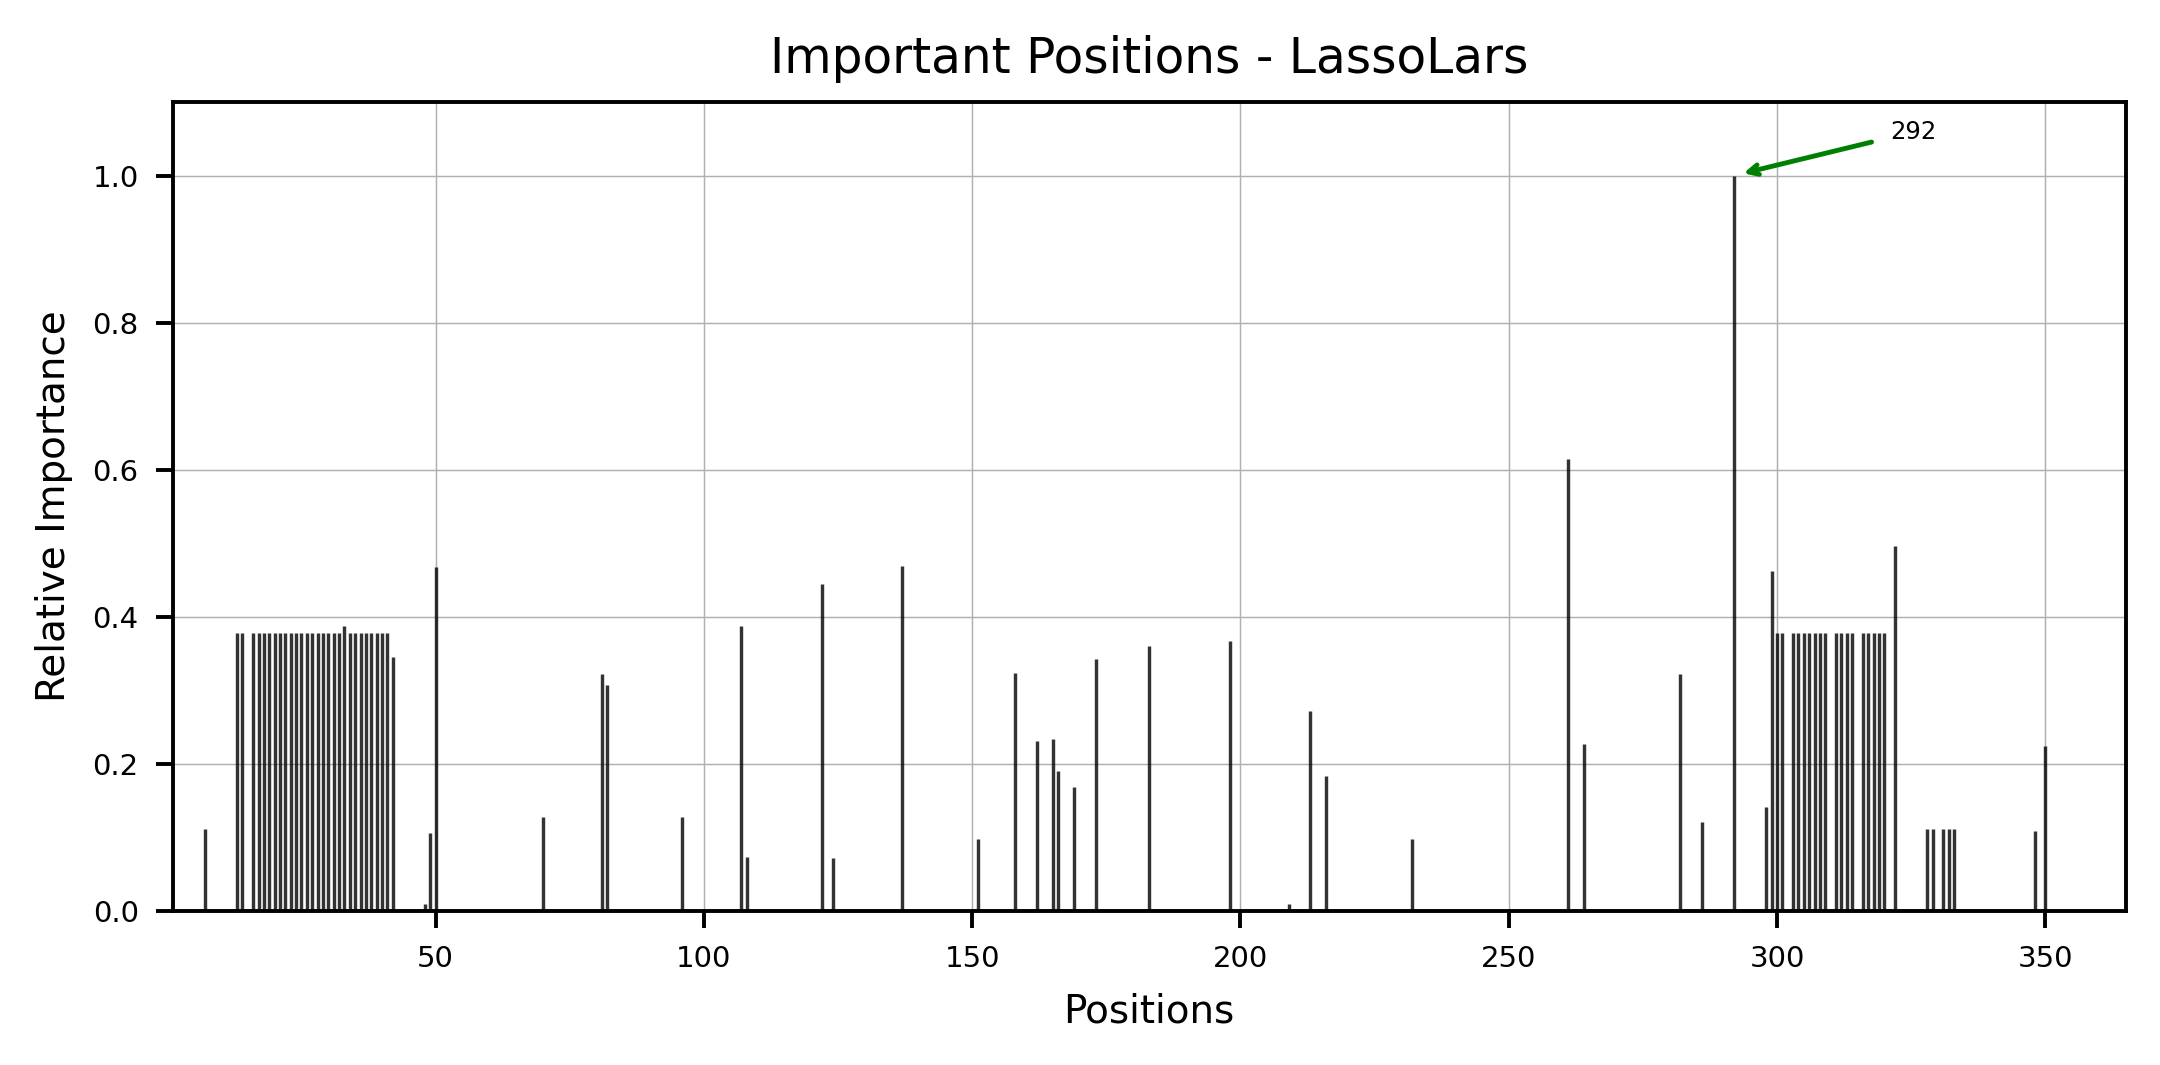

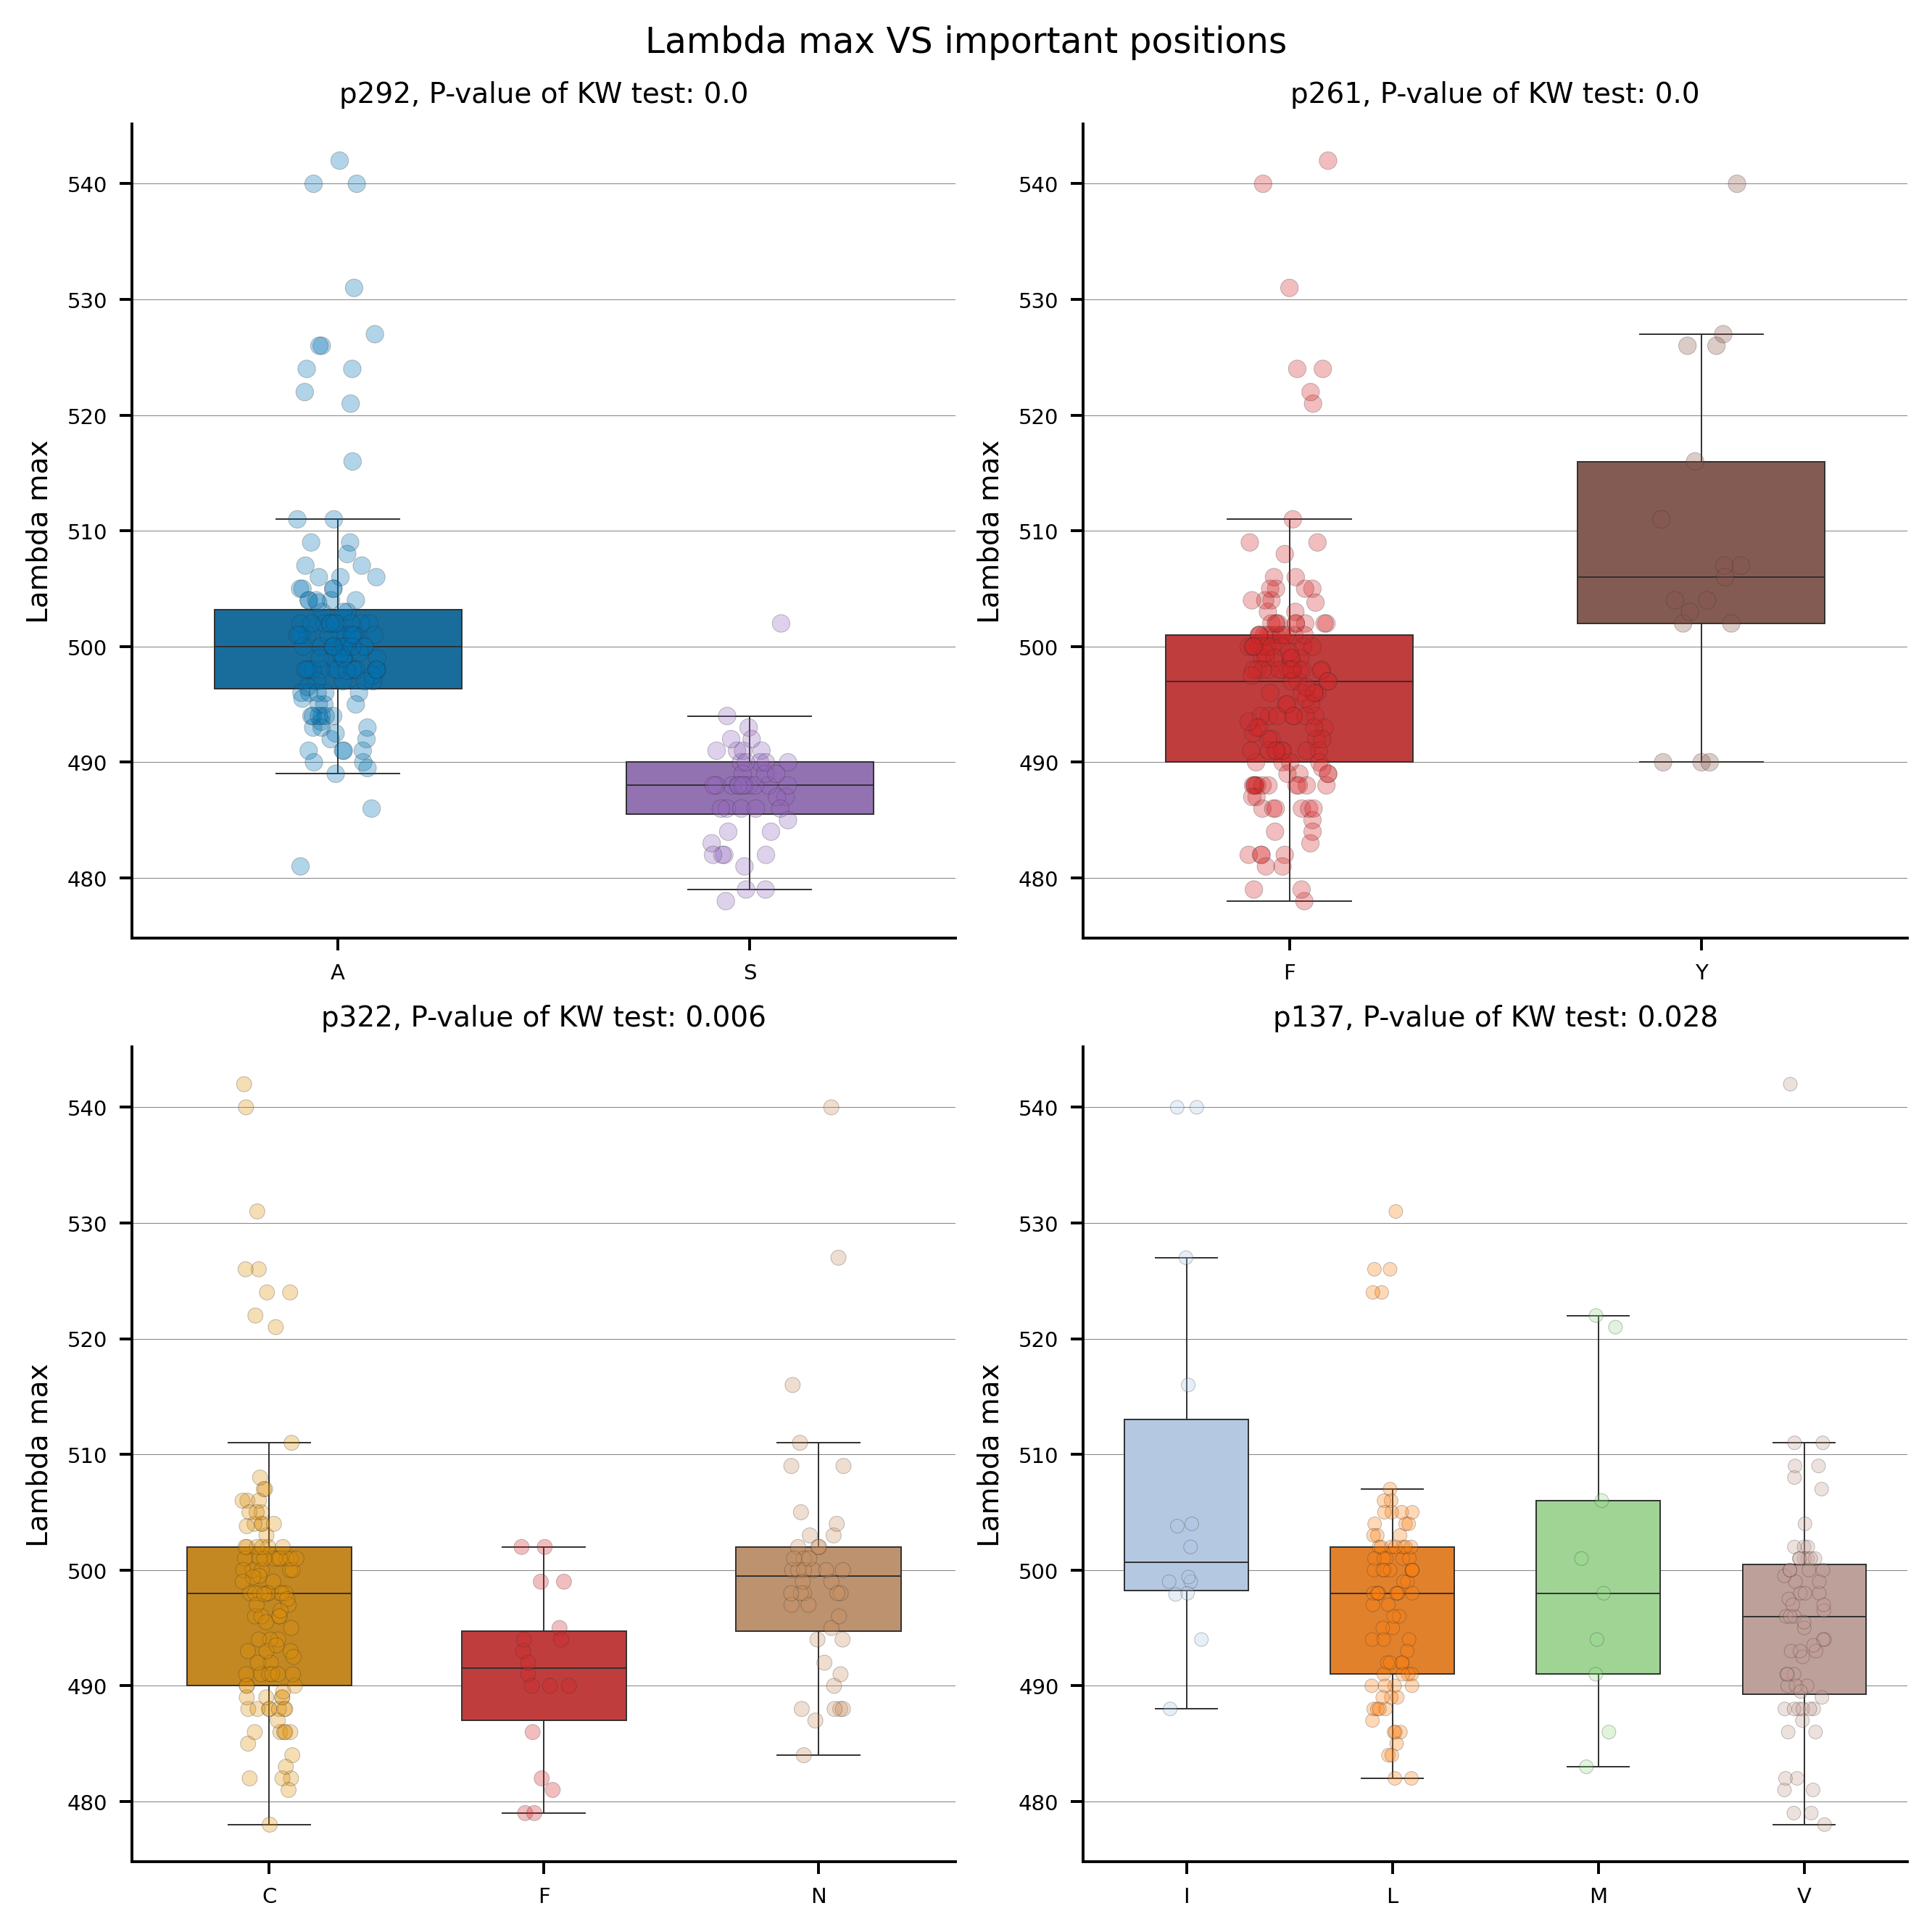

In [22]:
for model in top:
    model_name = model.steps[-1][0]
    dp_plot(importance=importance_from_pipe(model, aggregate_function='max'),
            imp_col='standard_value',
            model_name = model_name, report_dir=report_dir)
    
    plot_imp_model(importance=importance_from_pipe(model),
                   X_train=tr, y_train=y, model_name=model_name,
                   meta_var='Lambda max', model_type=ana_type,
                   report_dir=report_dir)

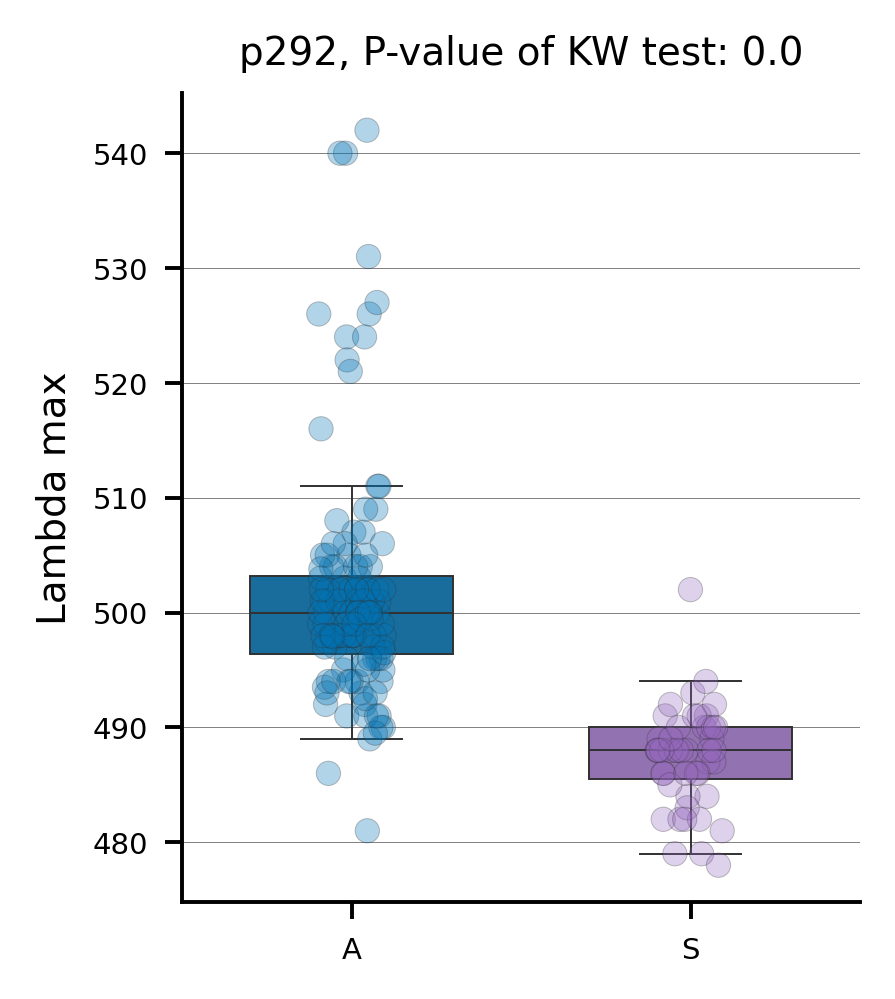

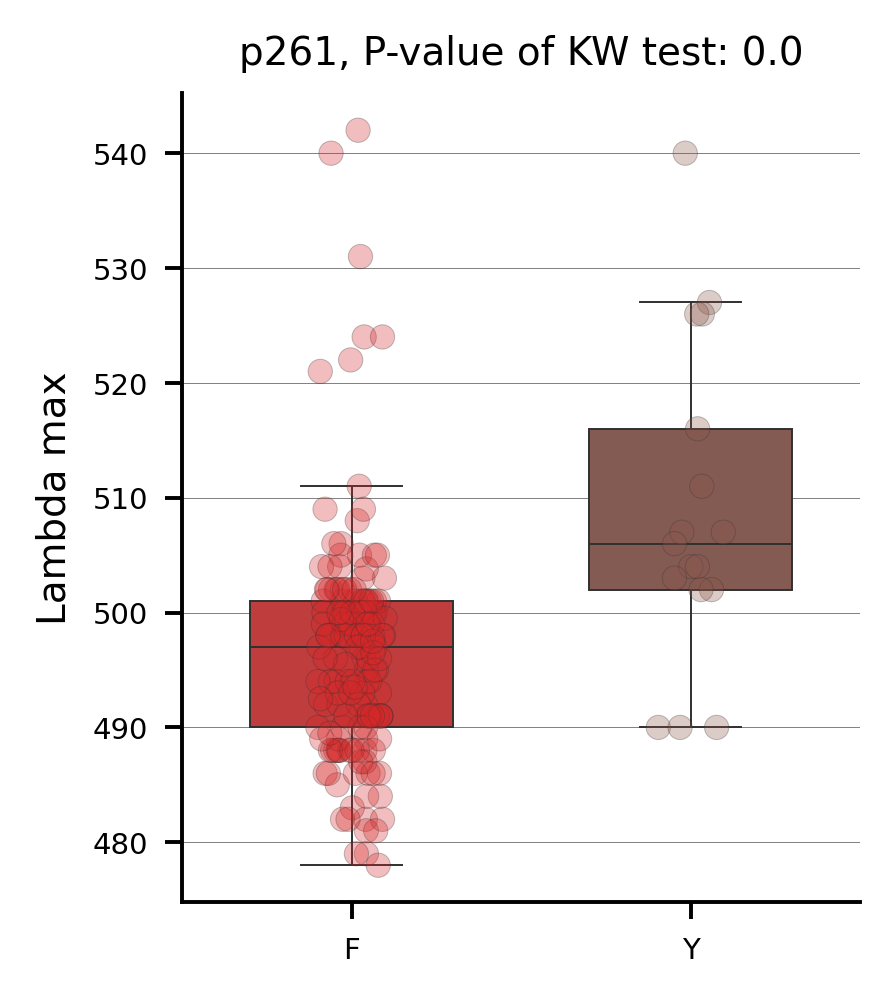

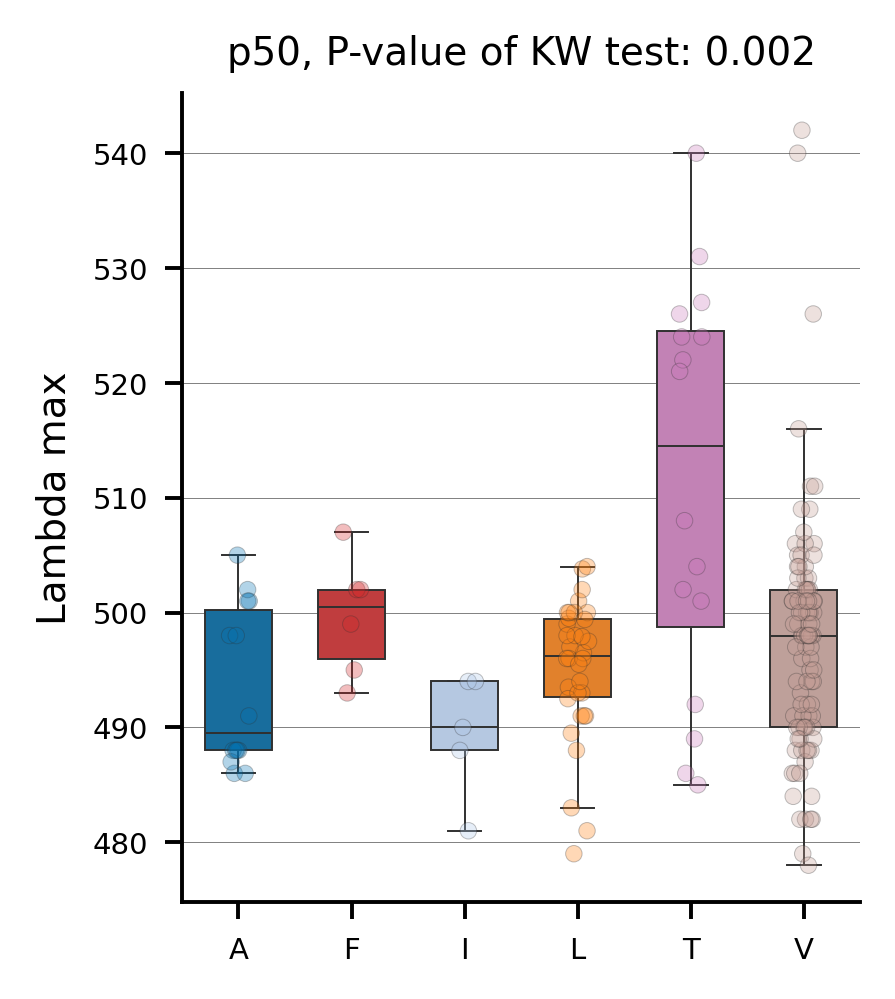

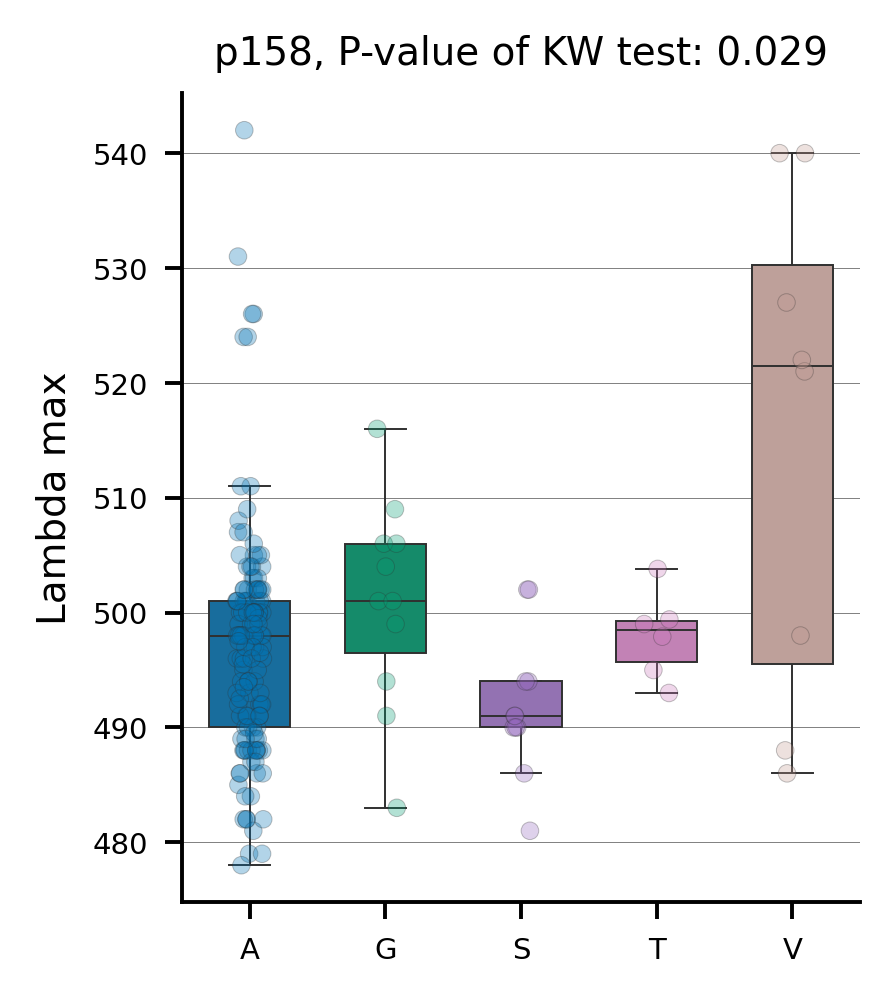

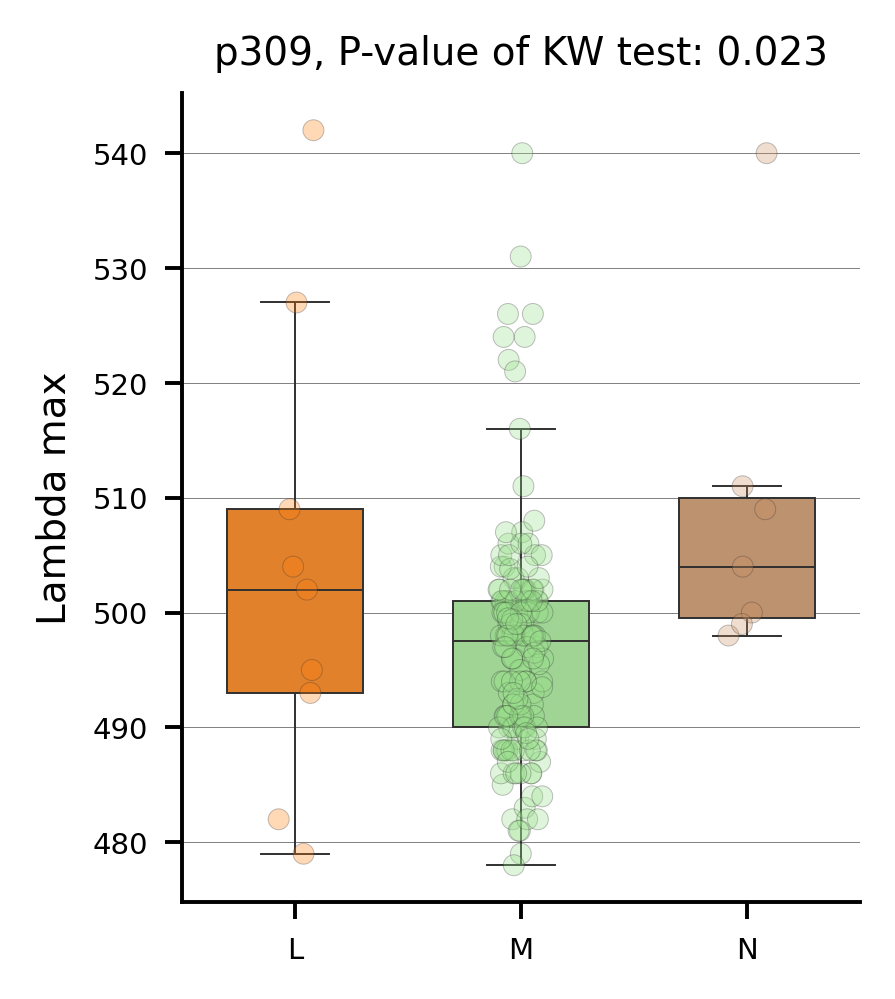

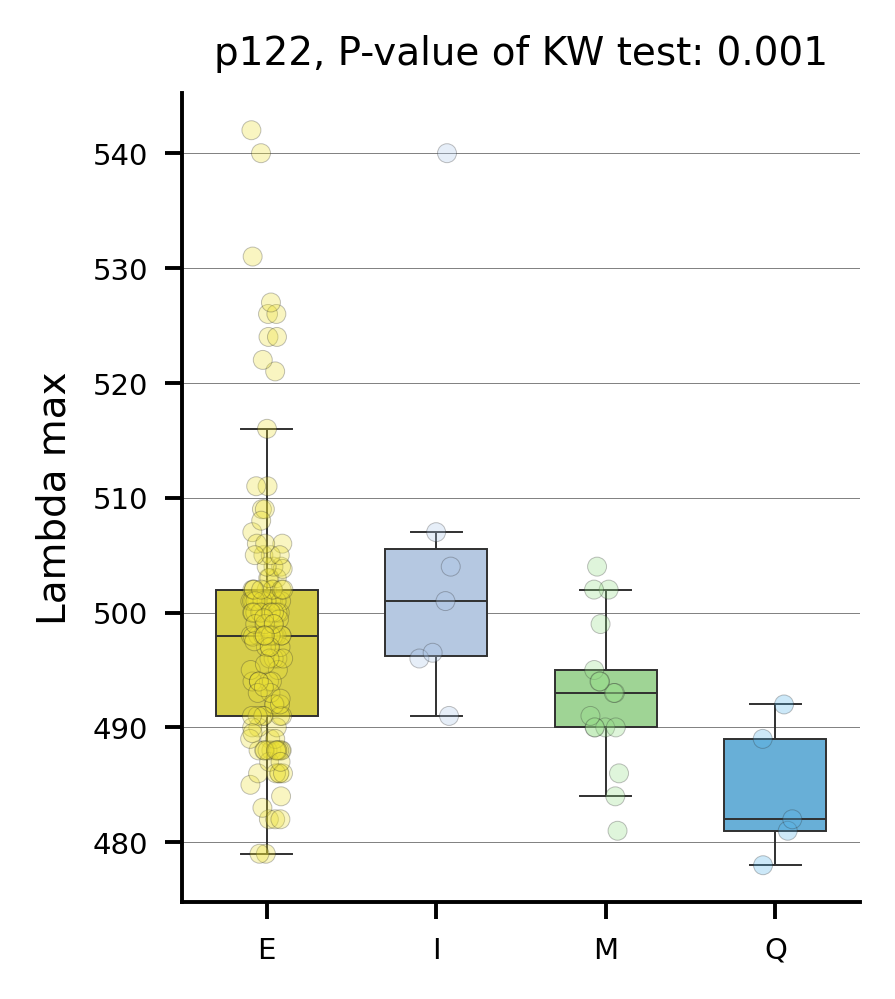

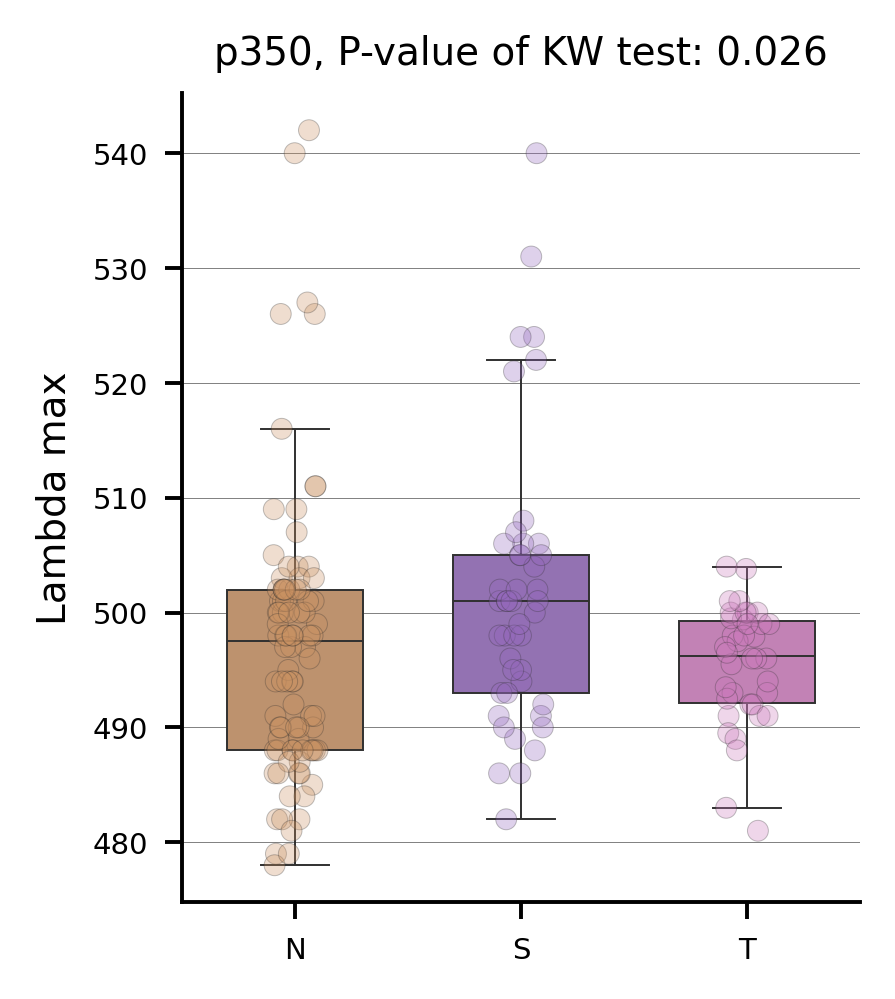

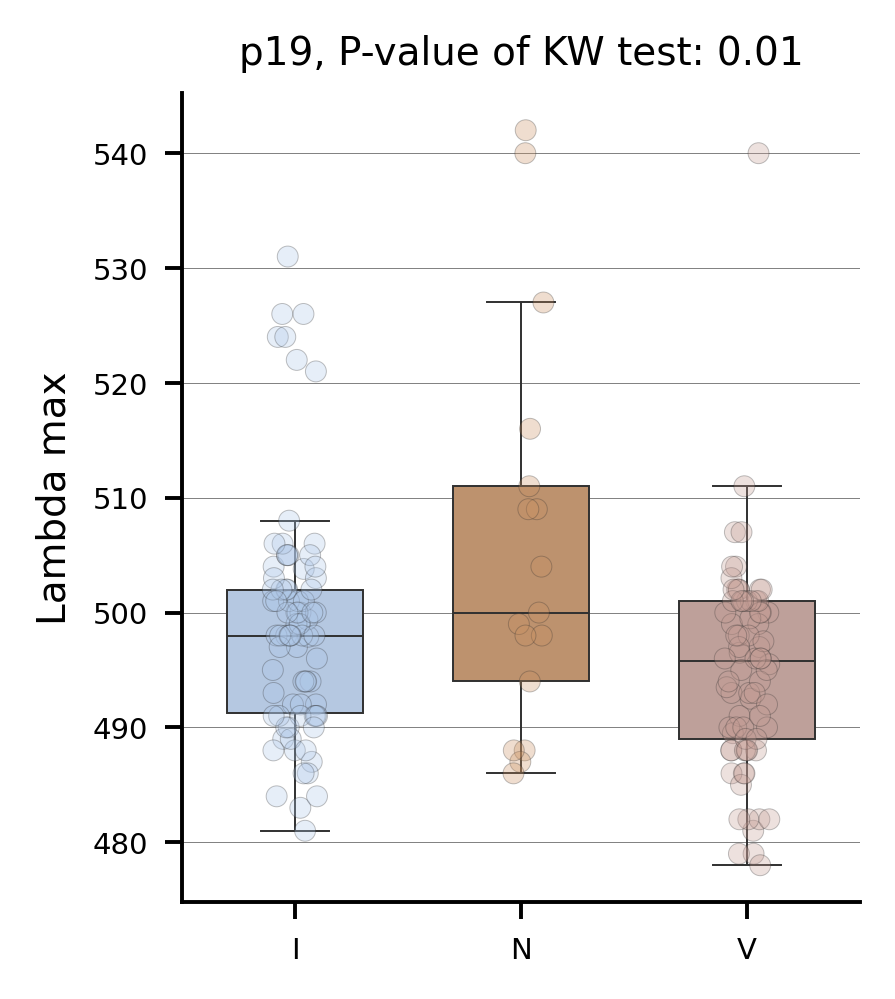

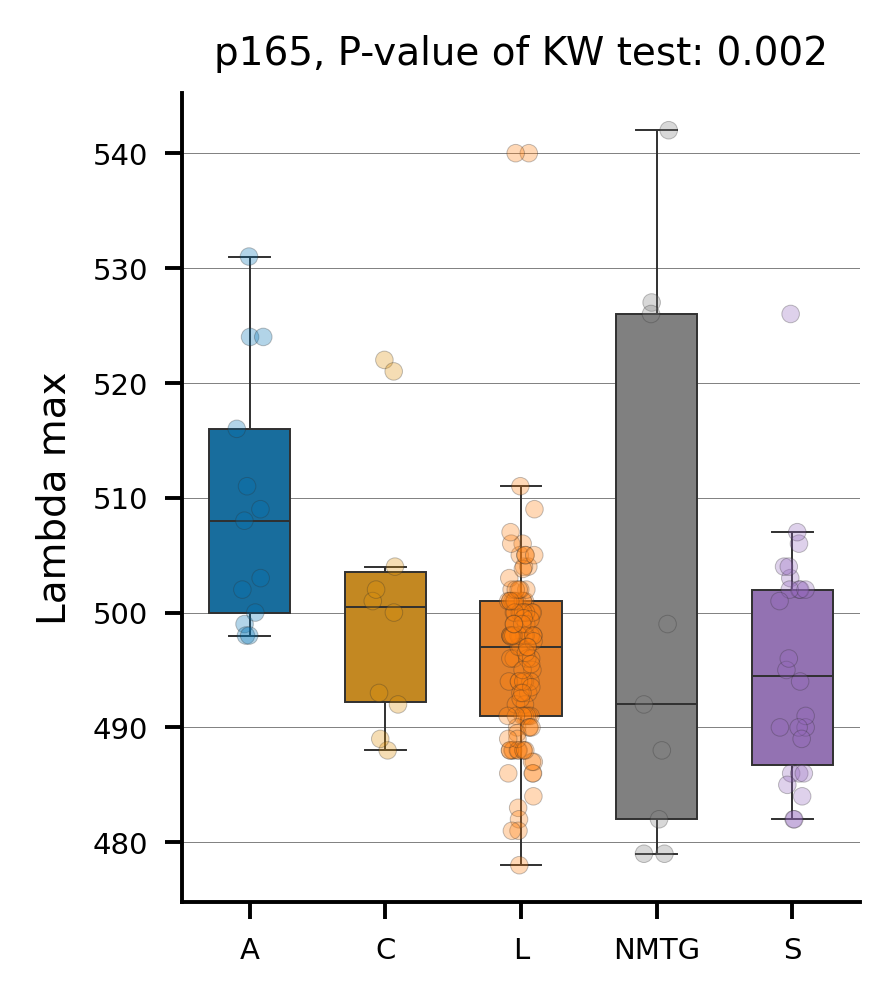

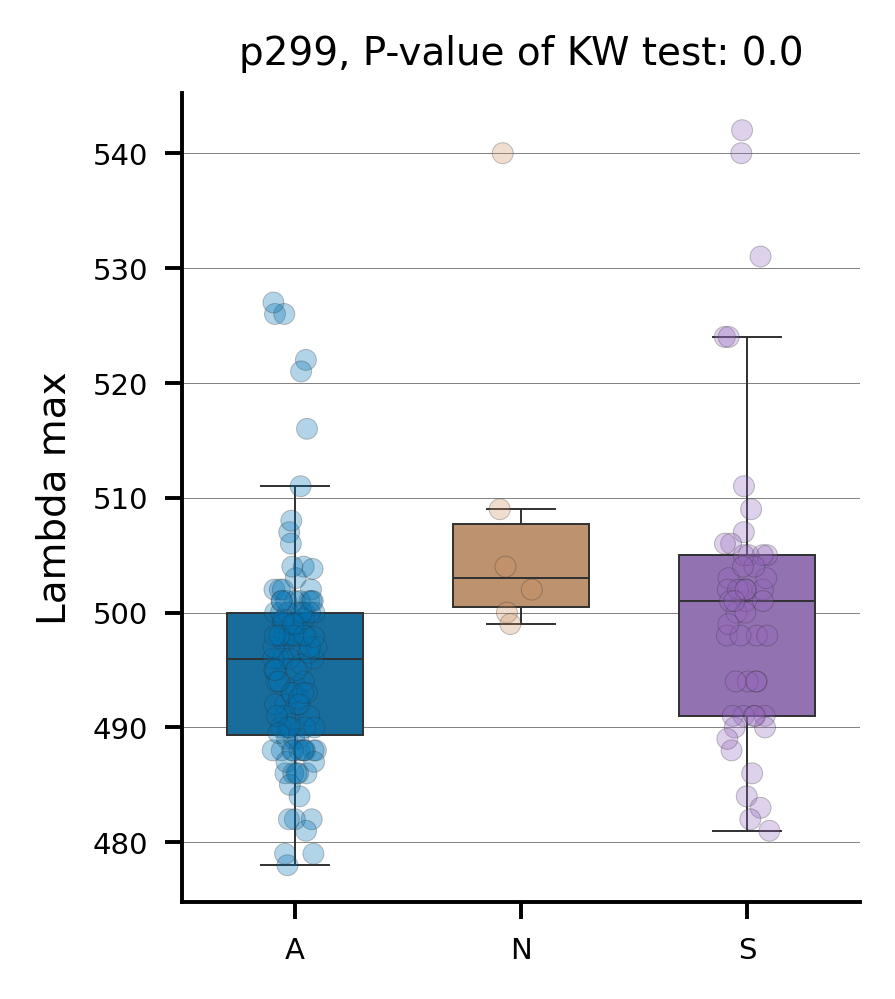

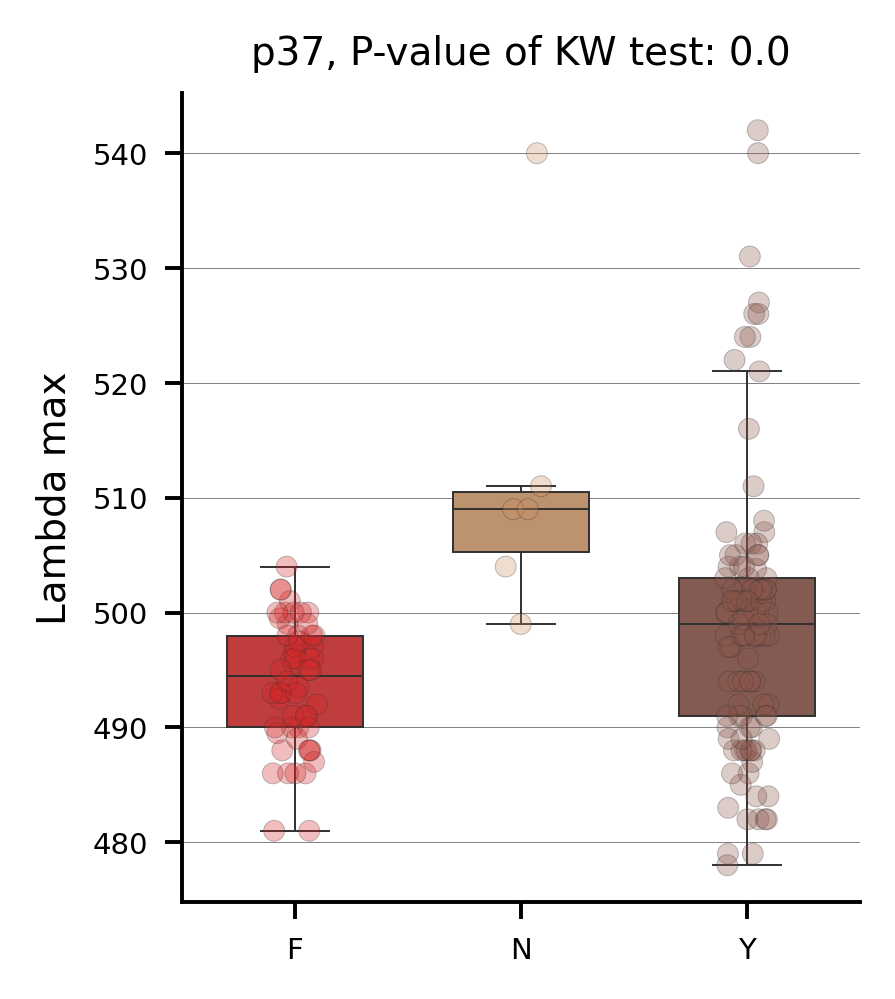

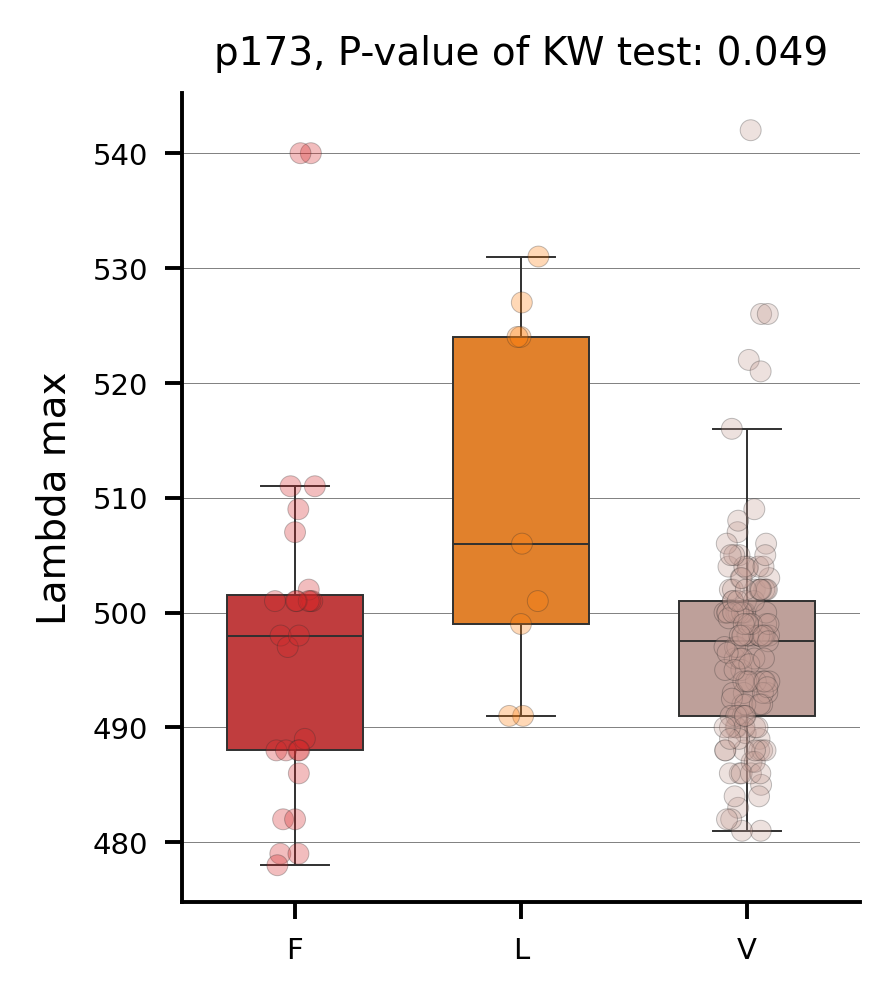

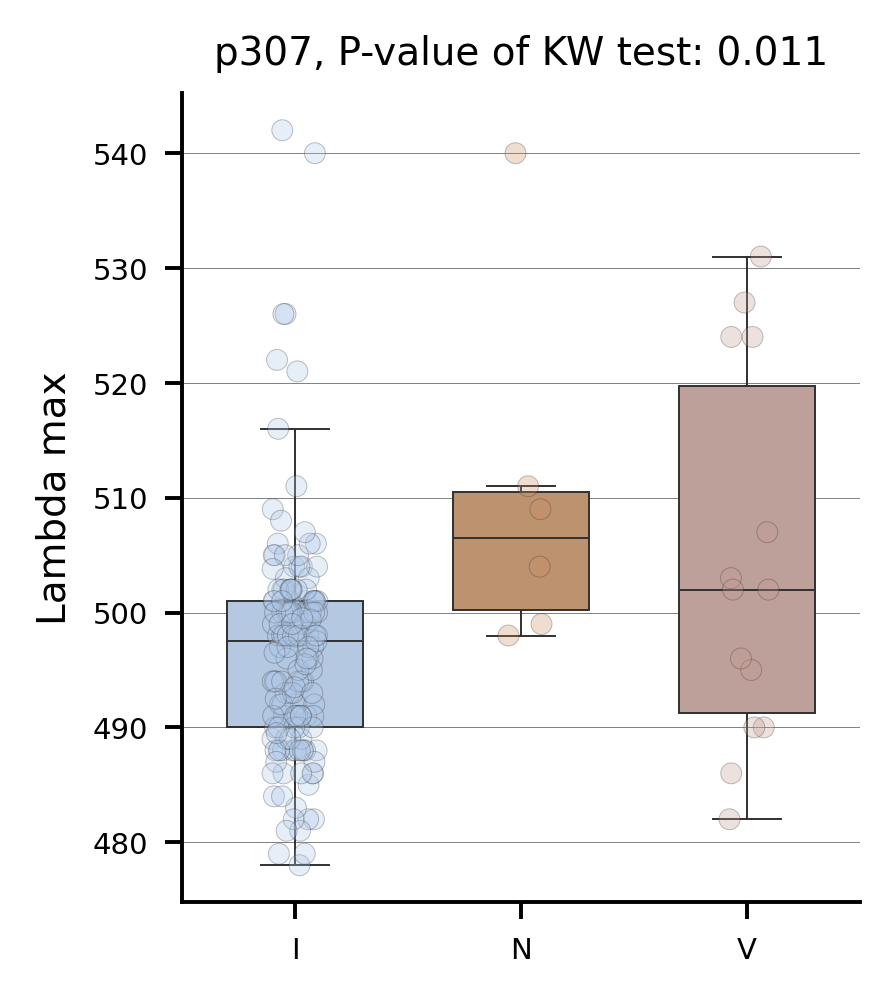

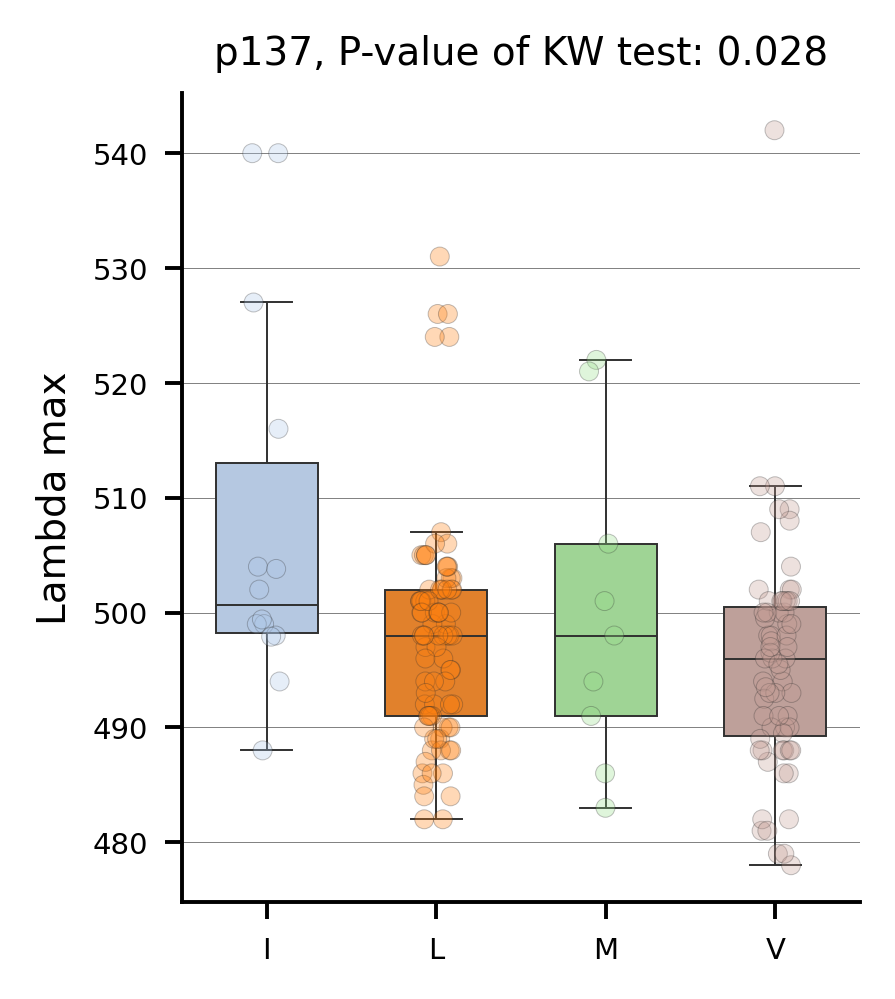

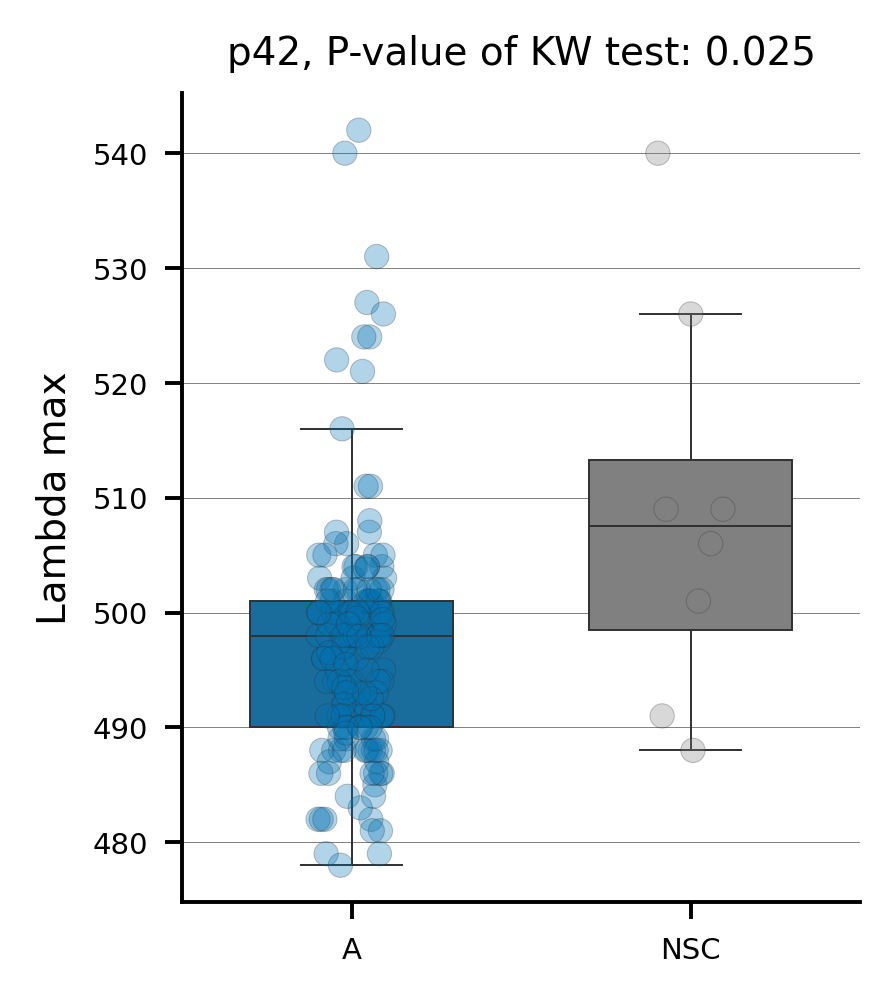

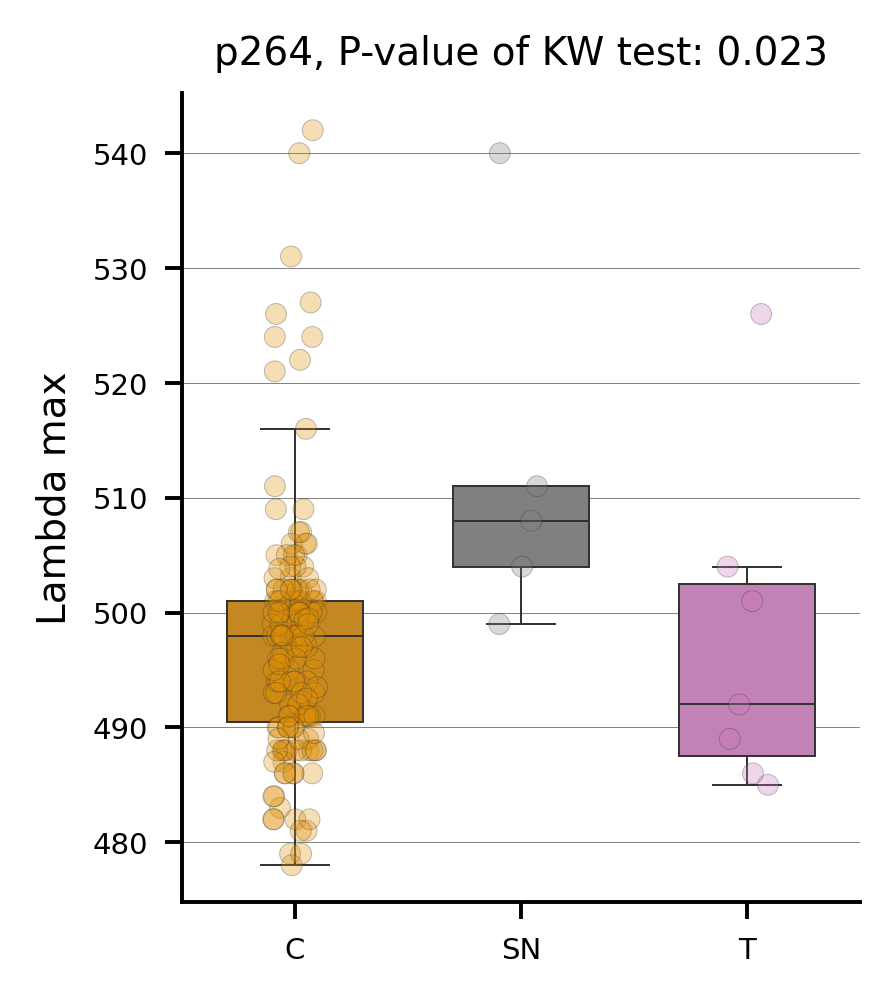

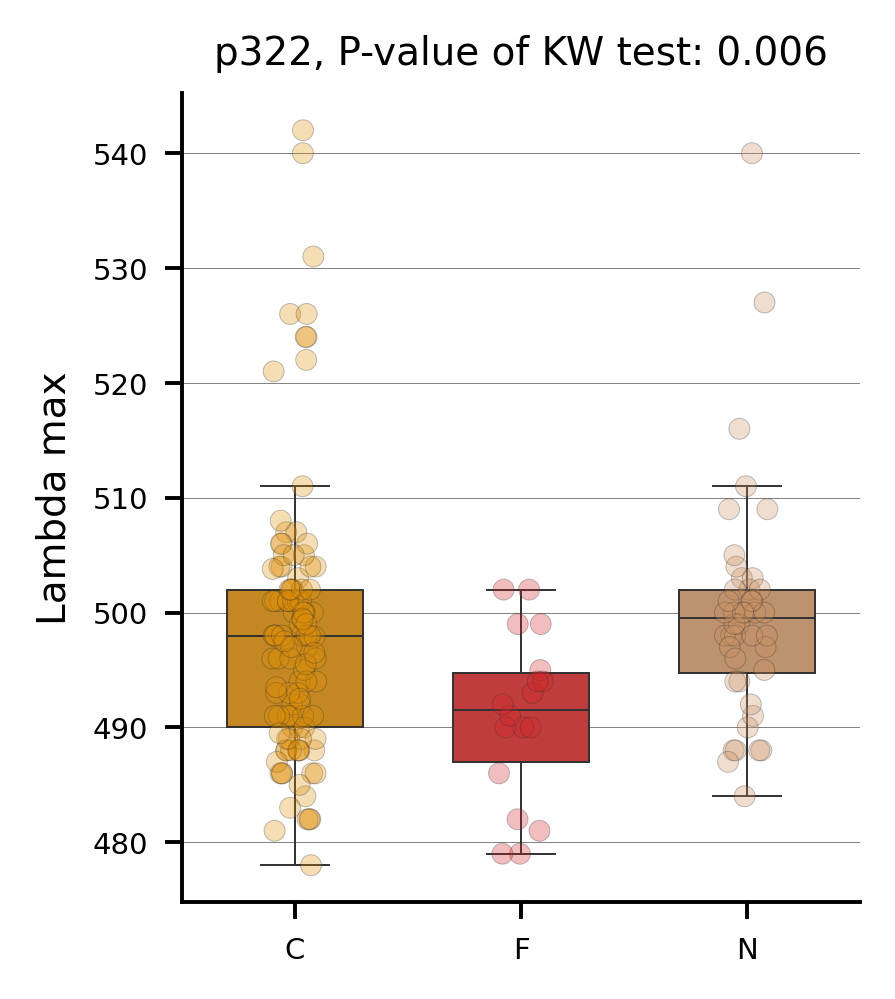

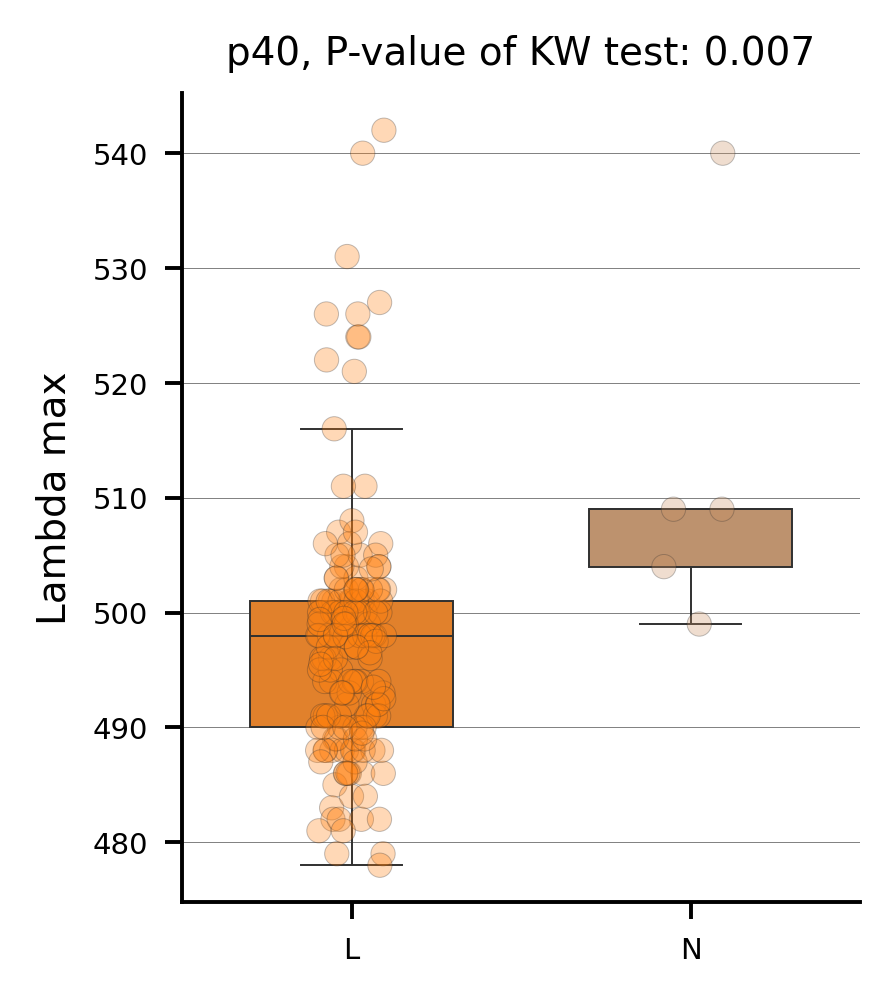

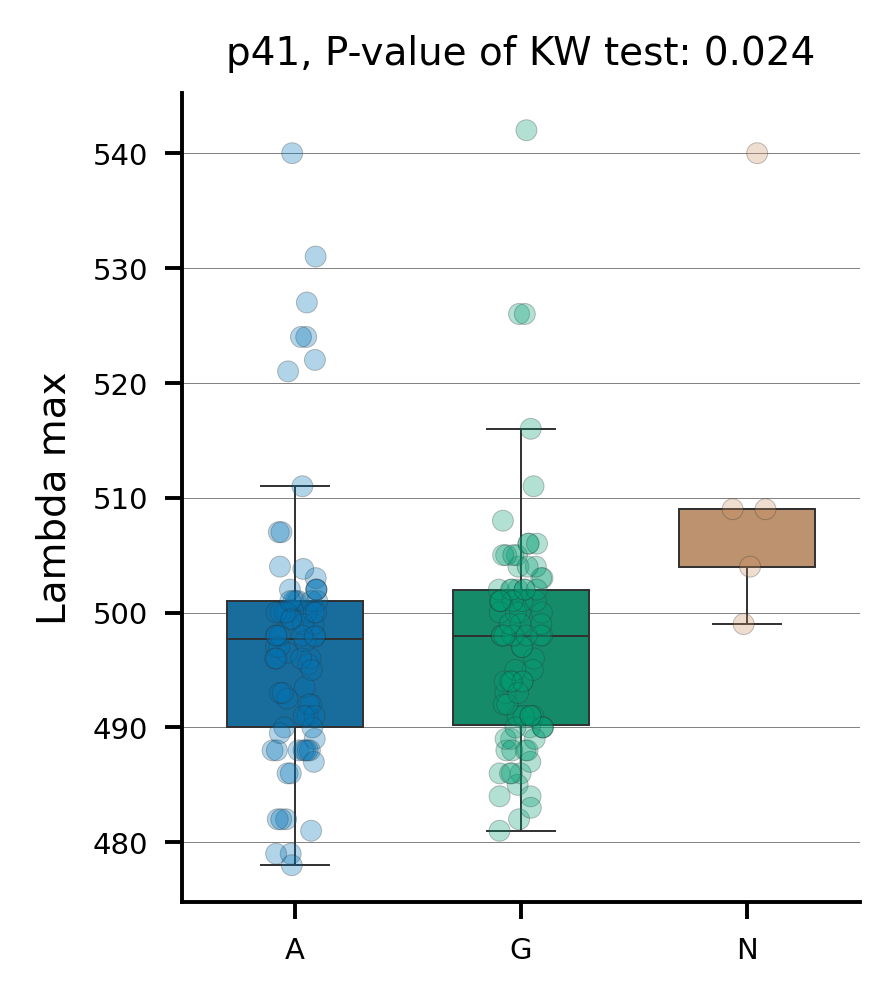

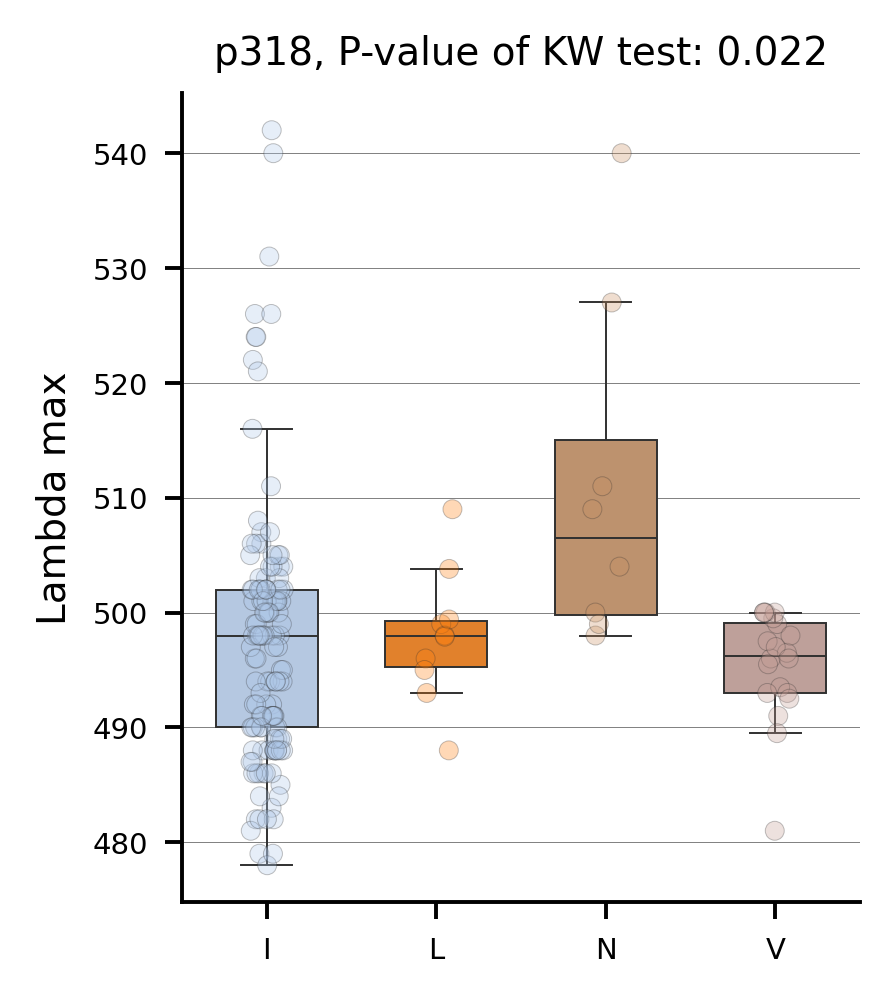

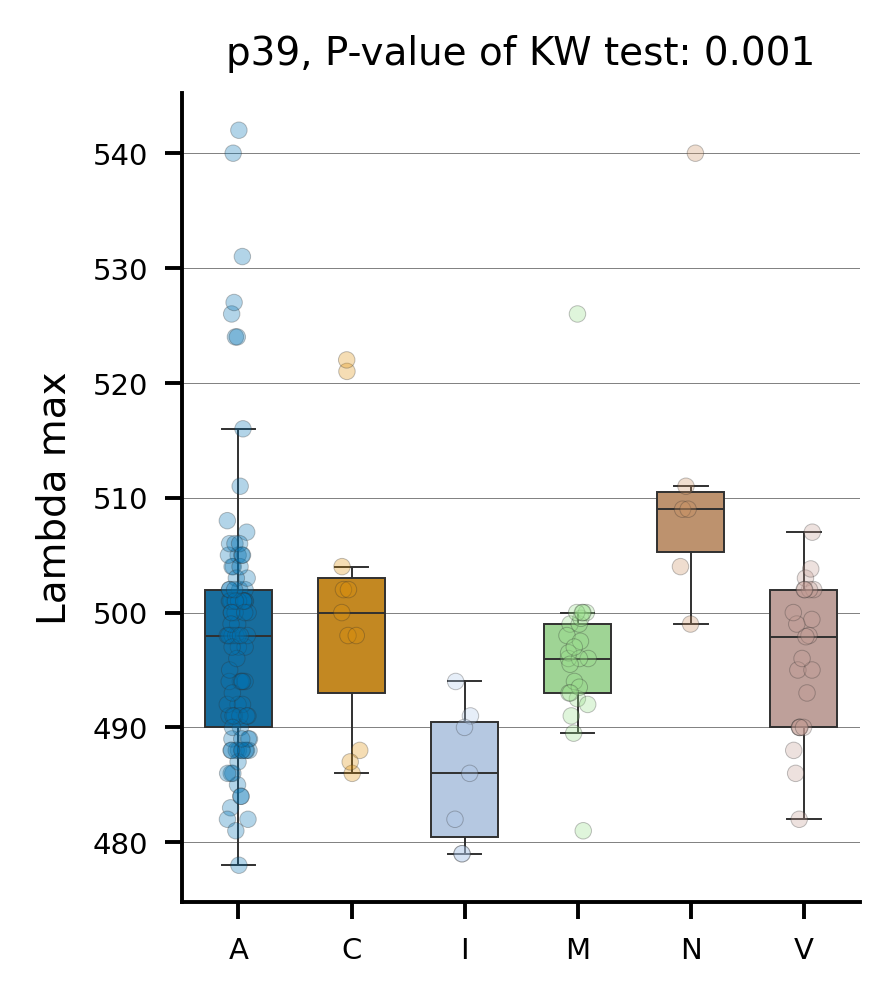

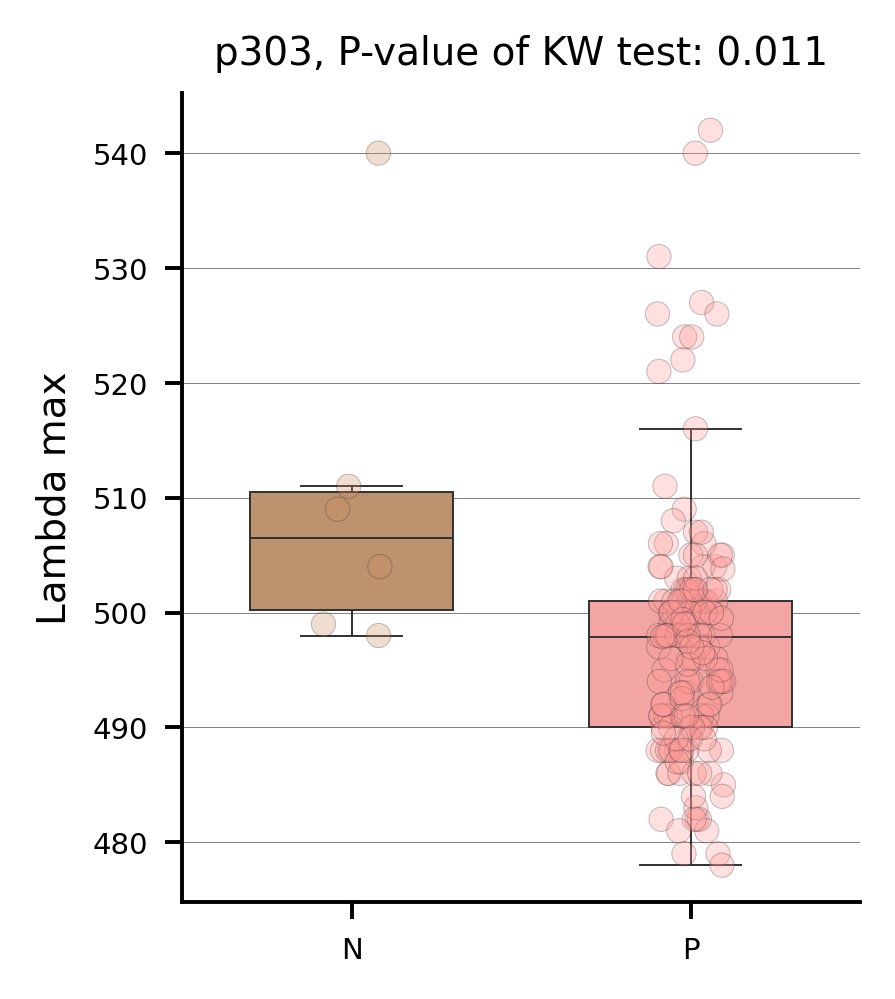

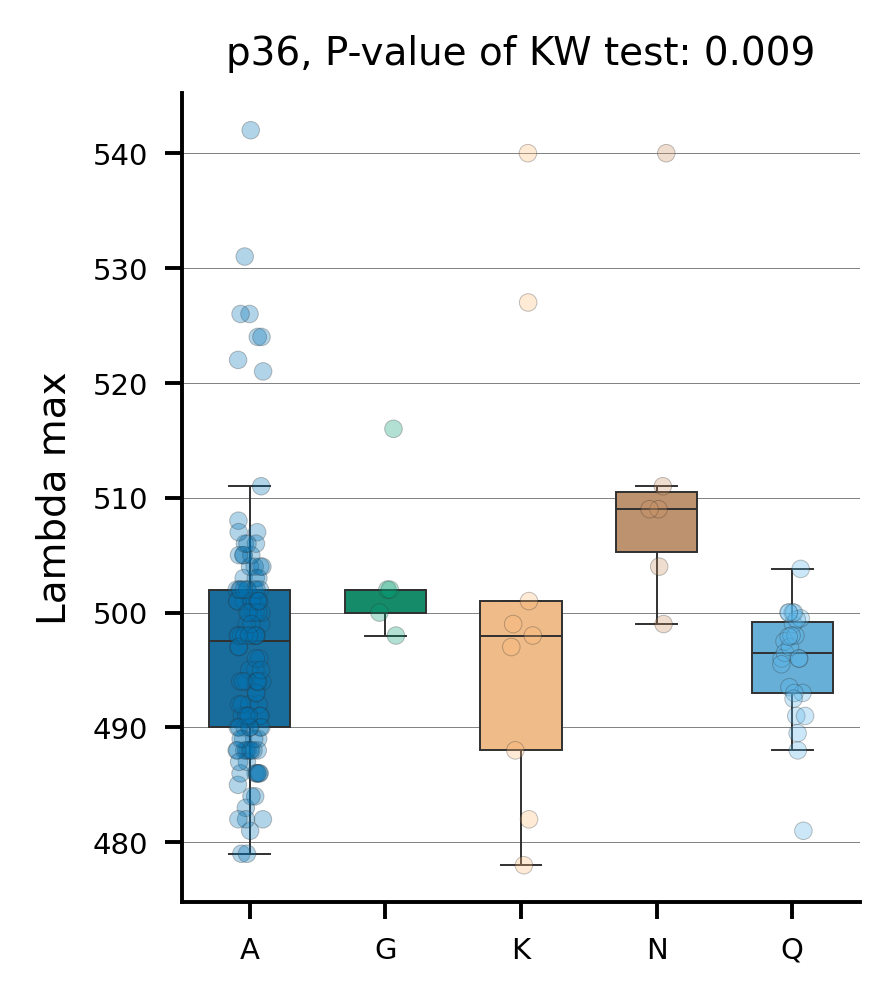

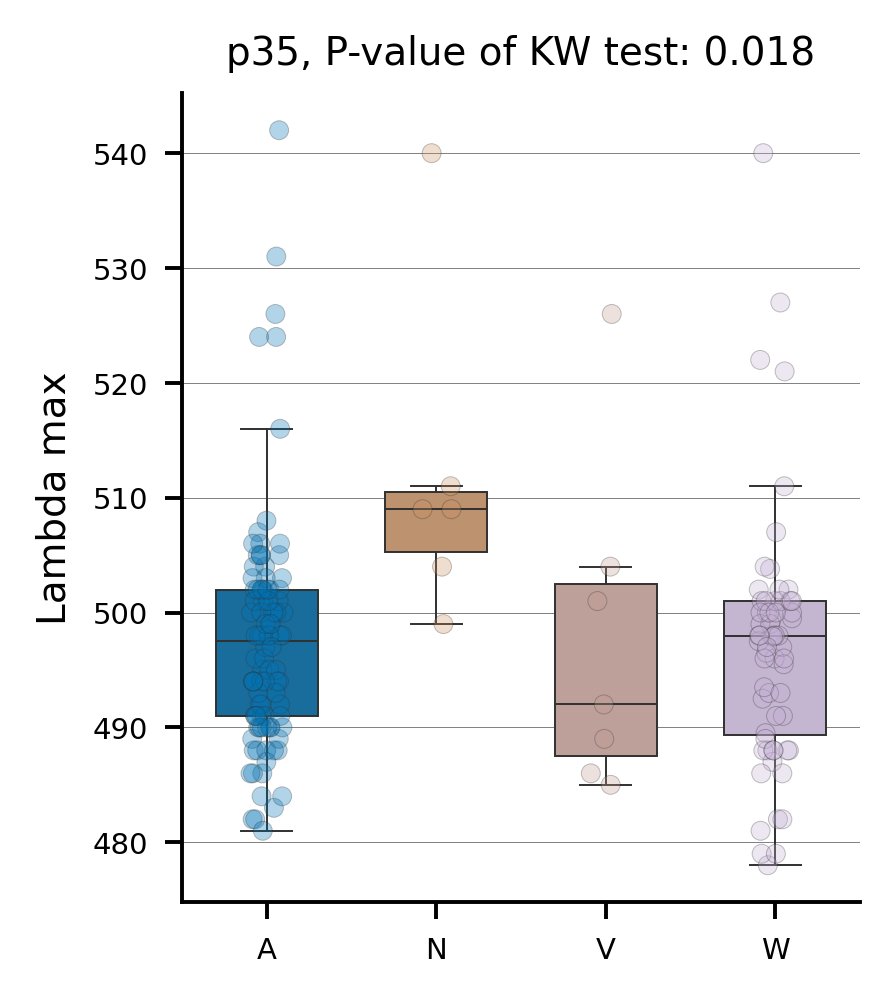

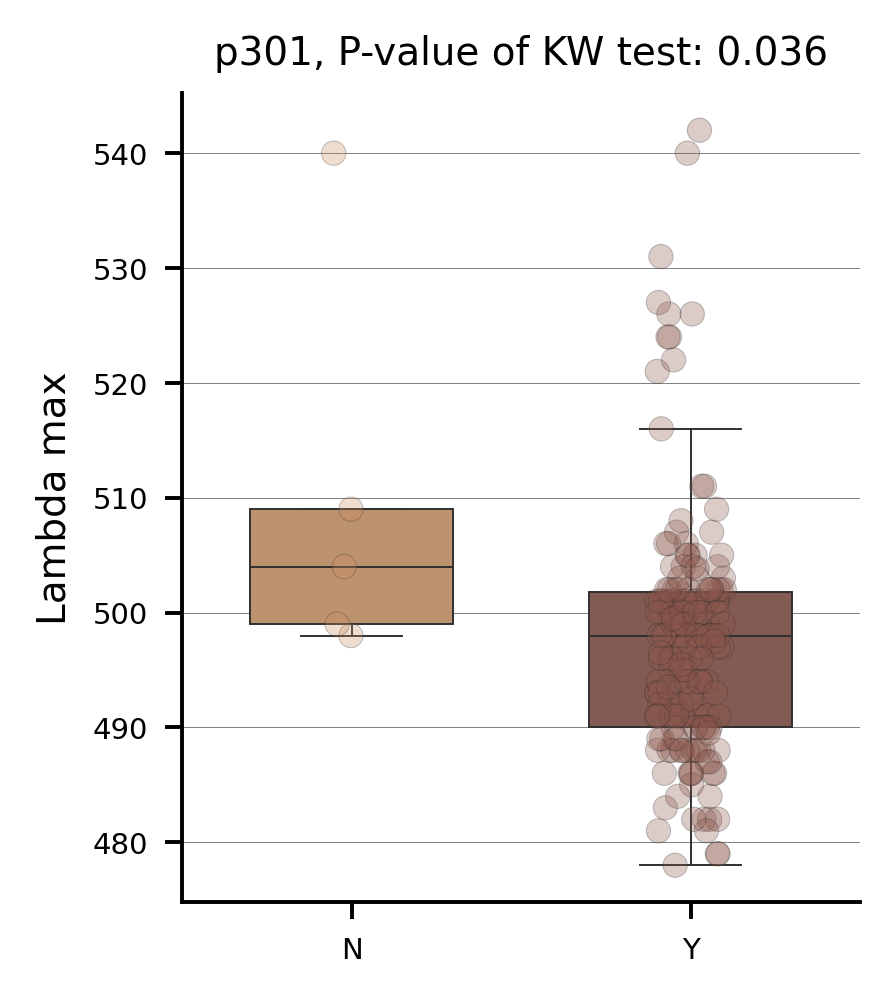

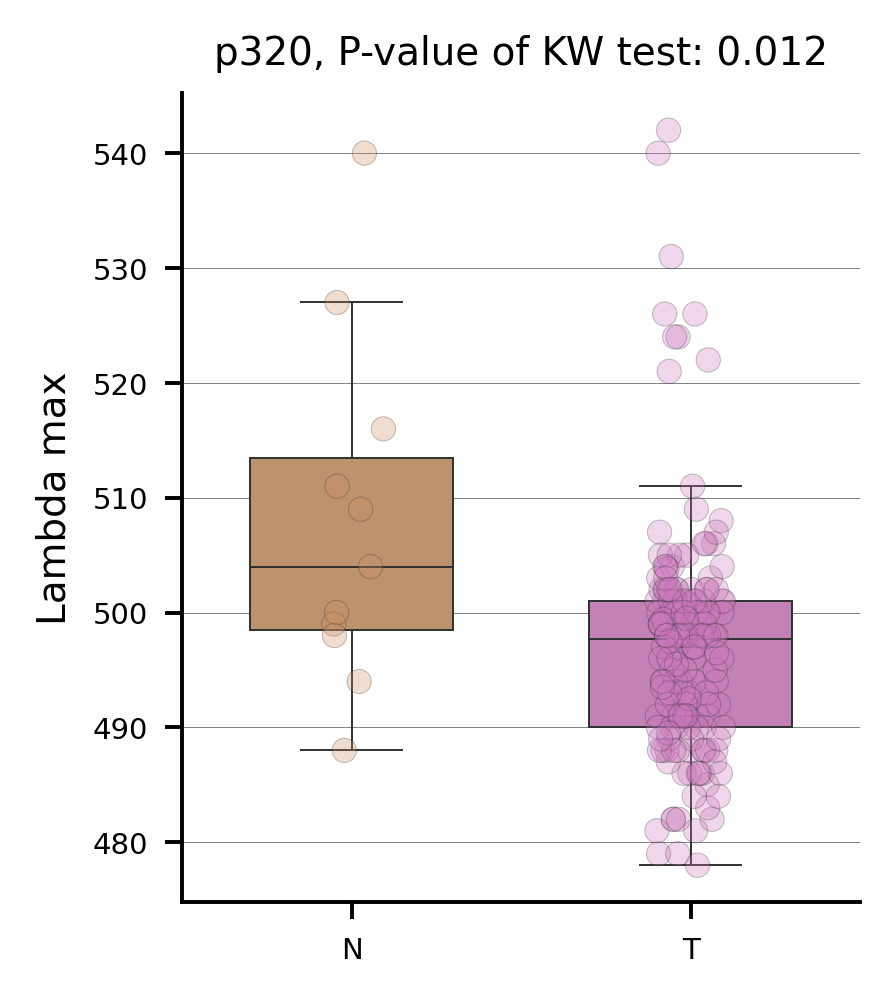

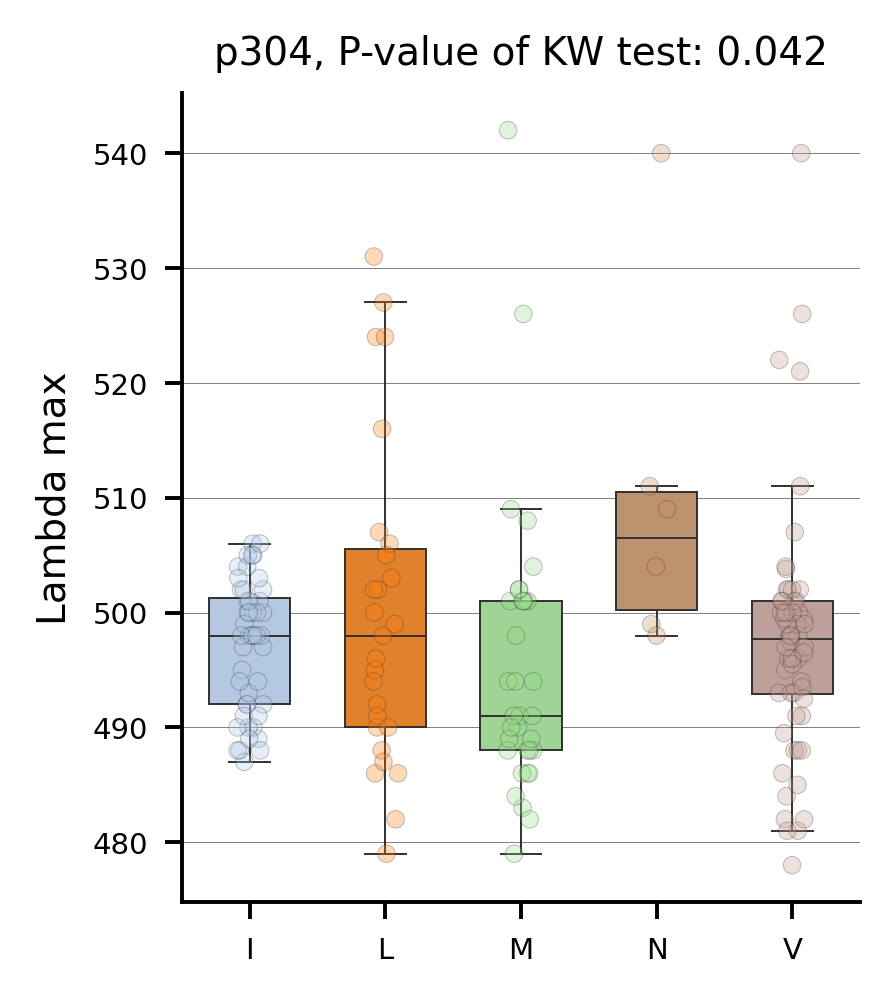

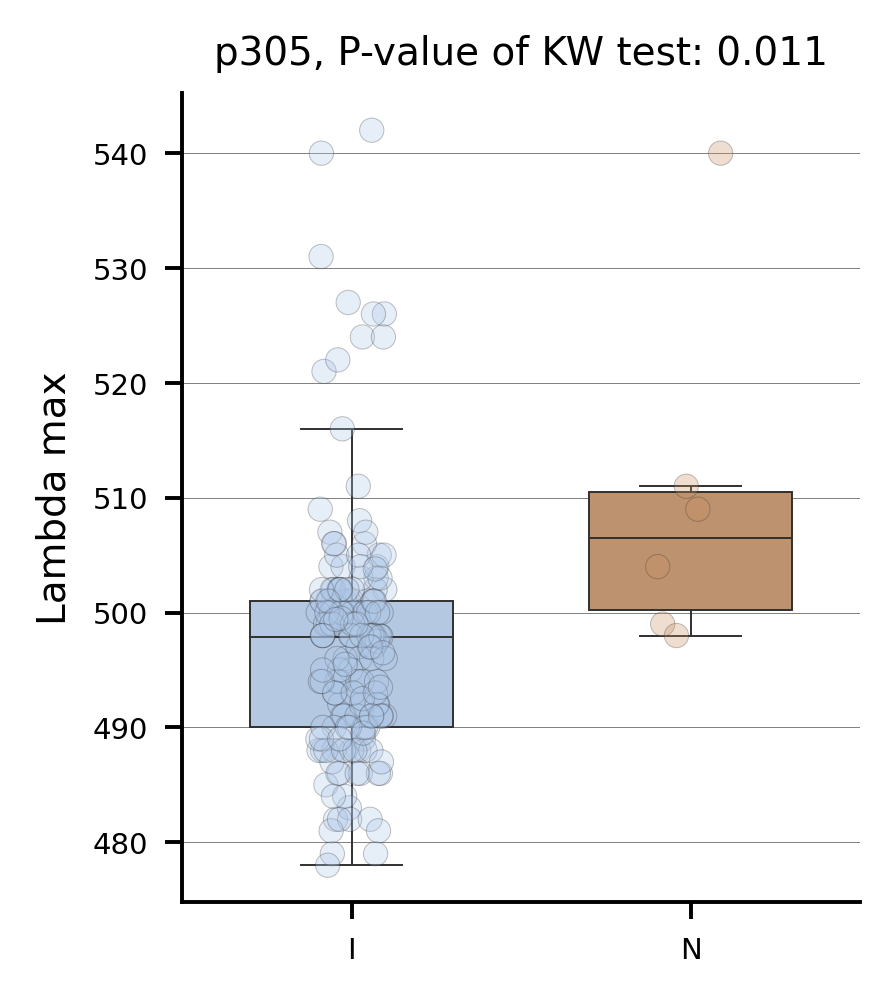

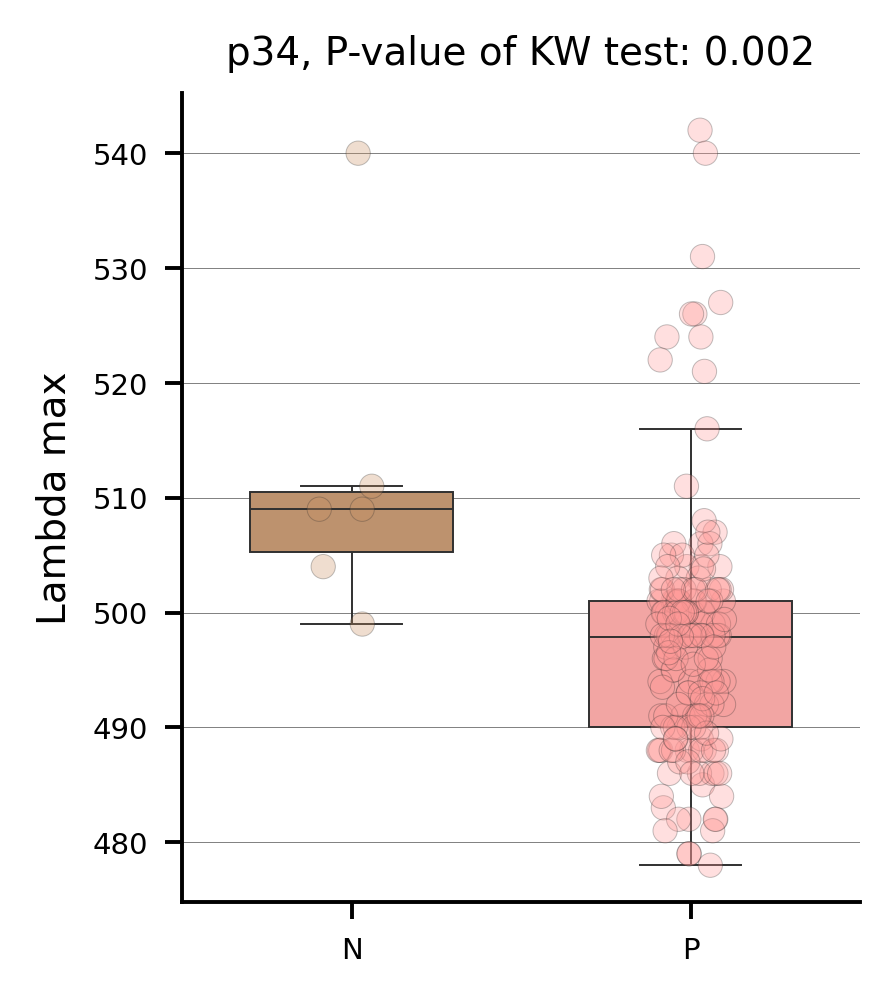

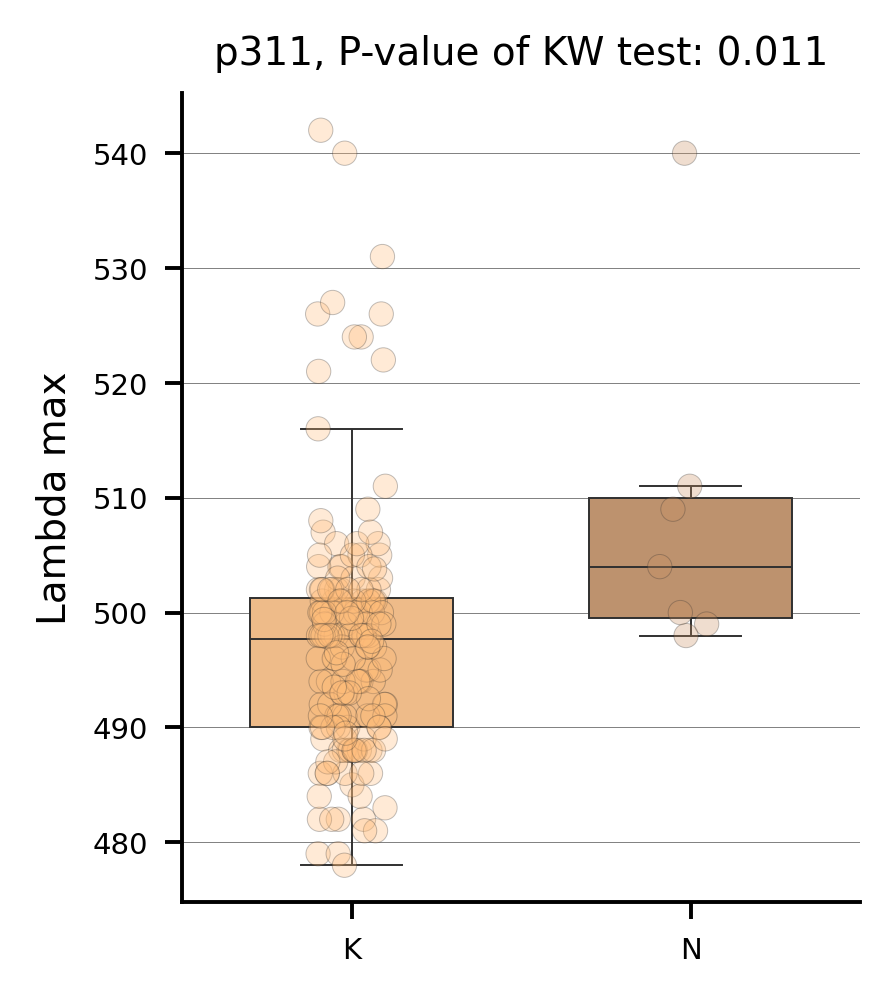

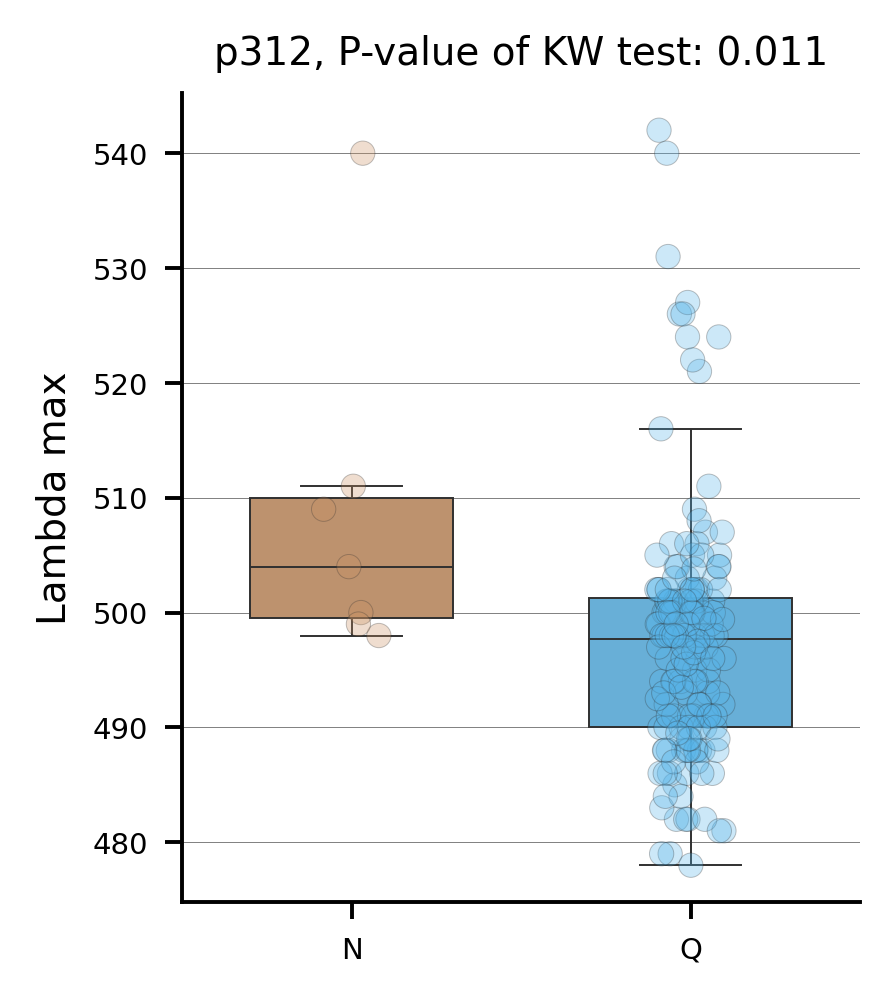

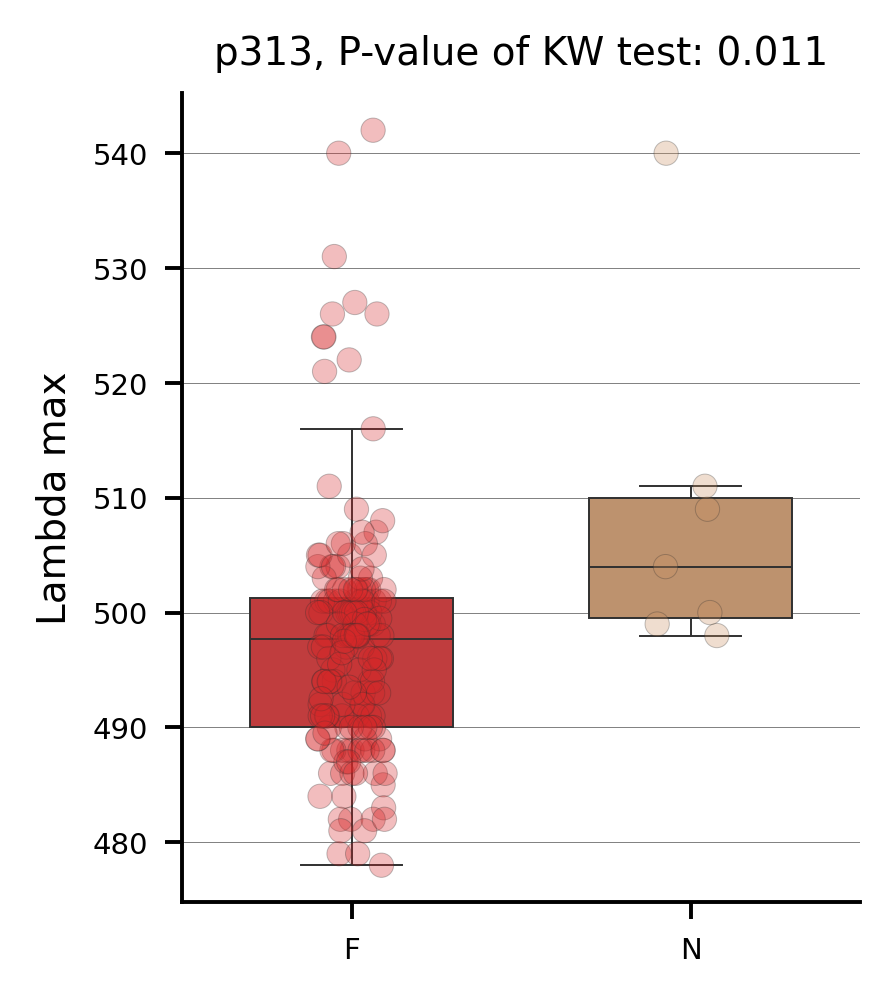

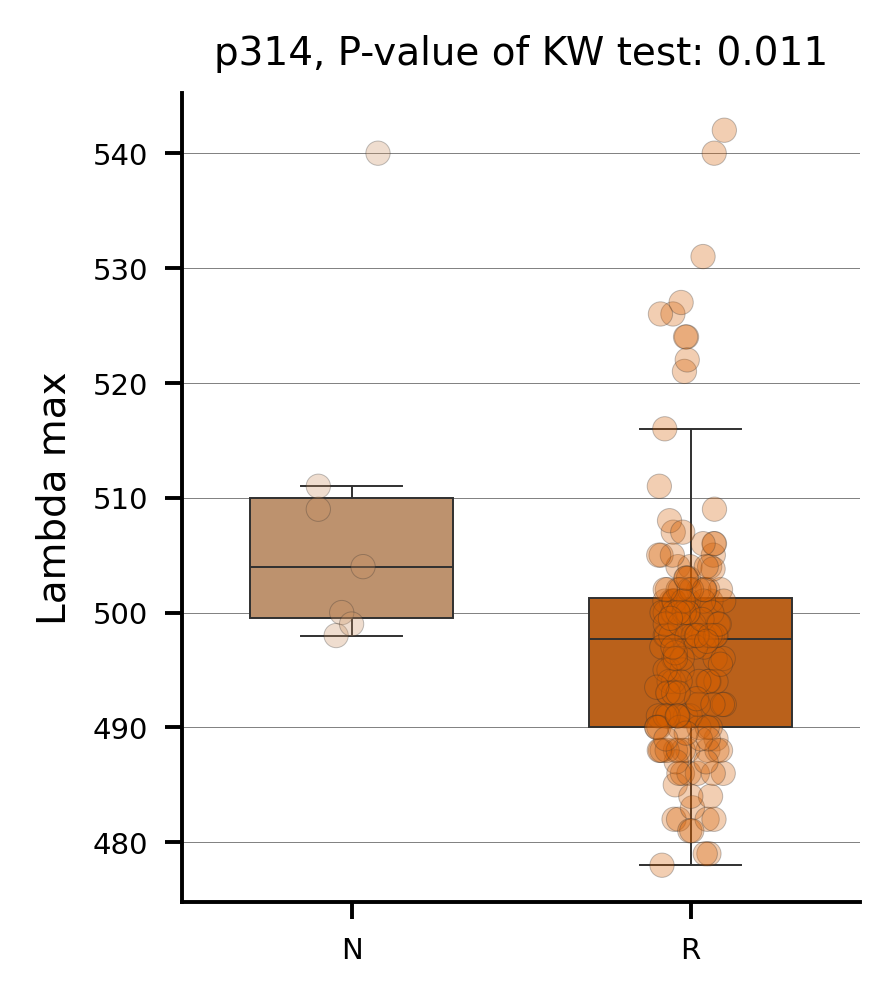

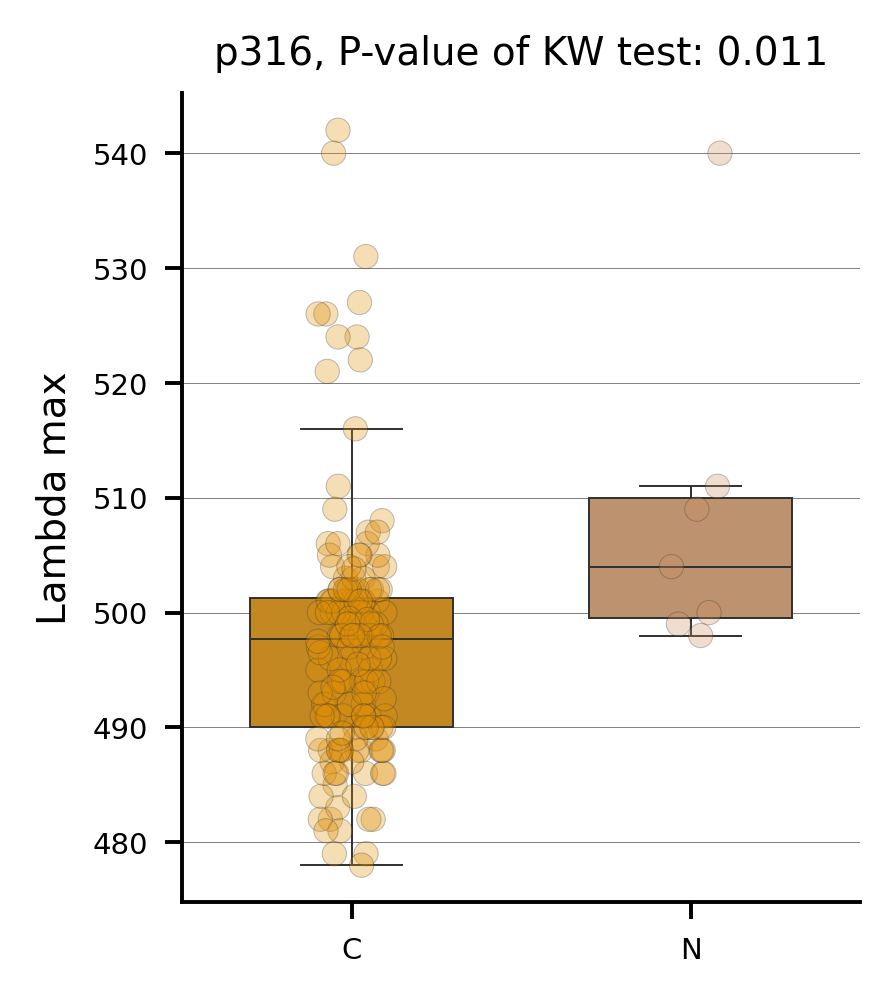

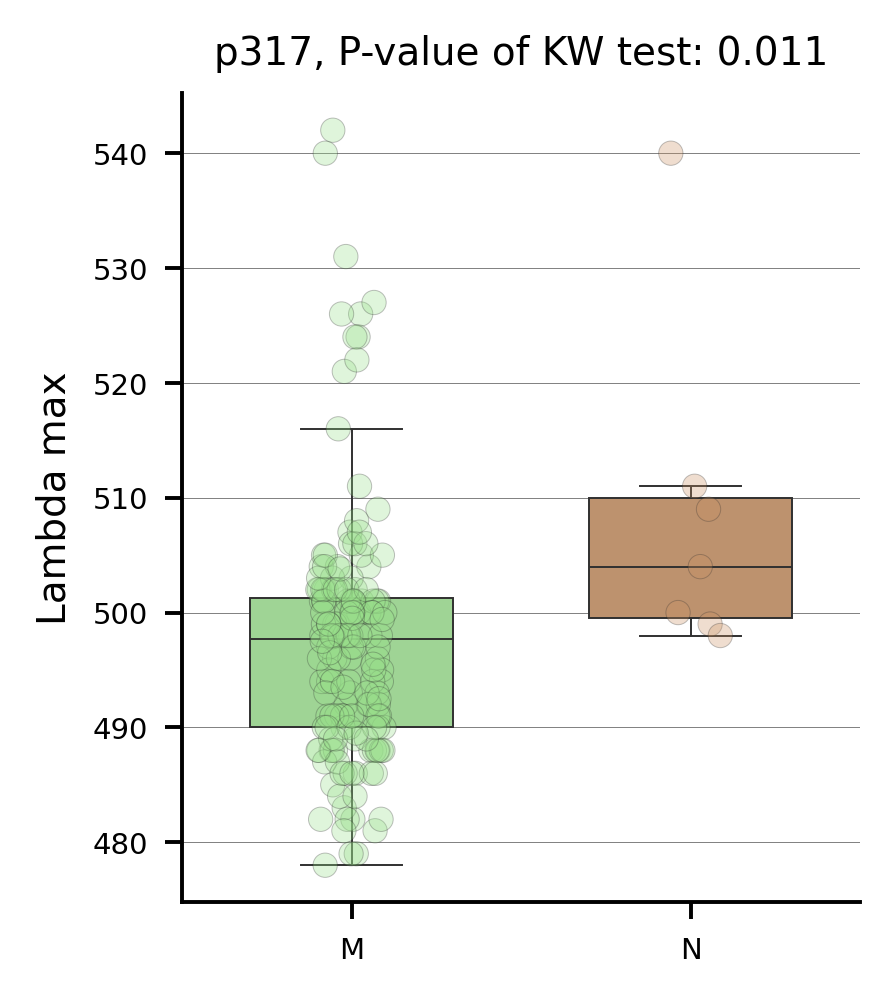

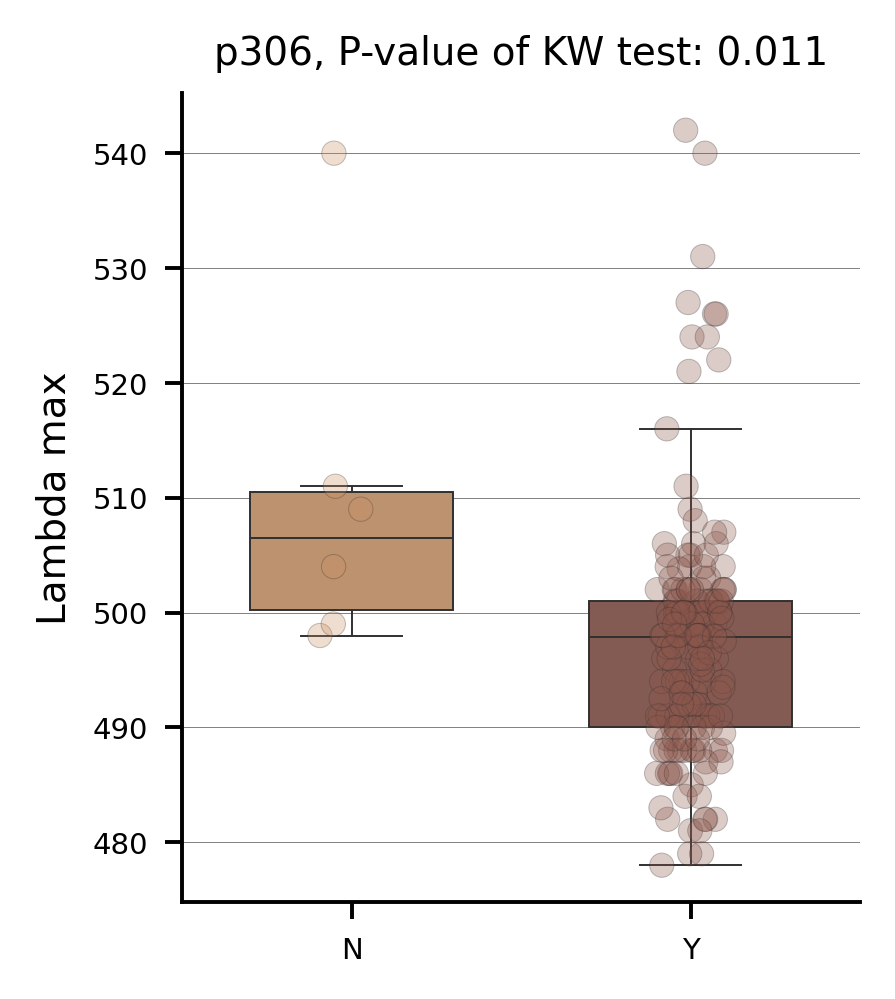

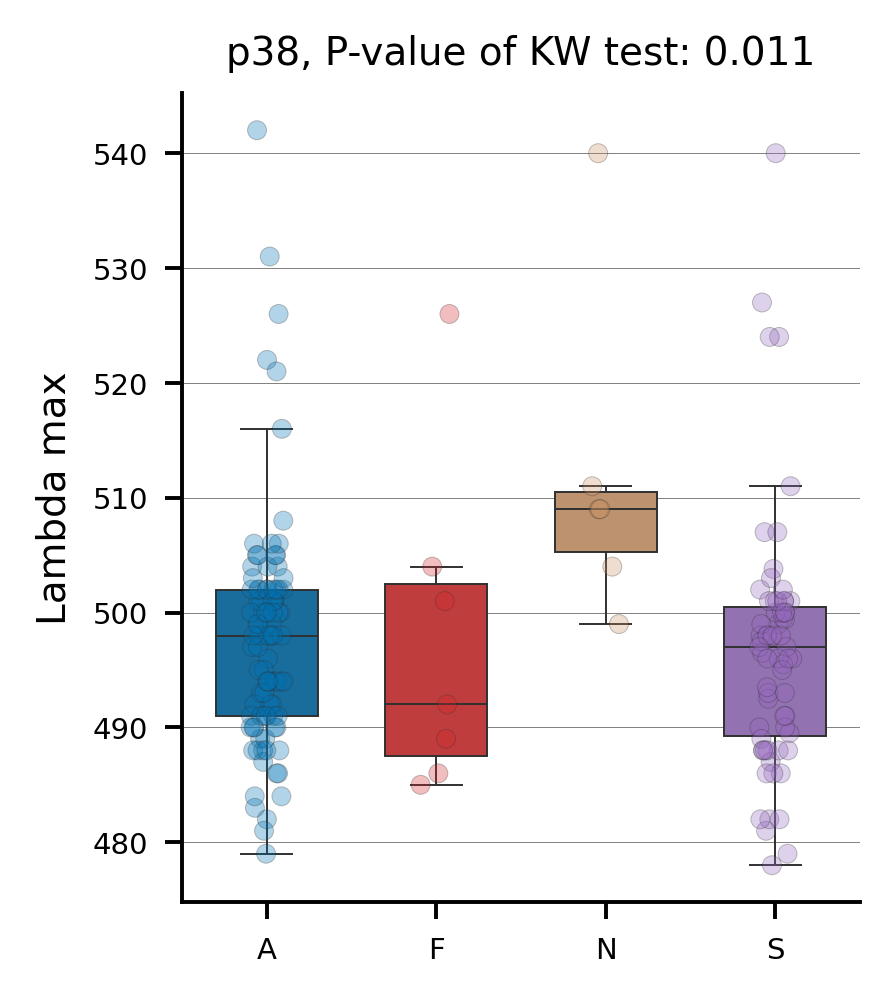

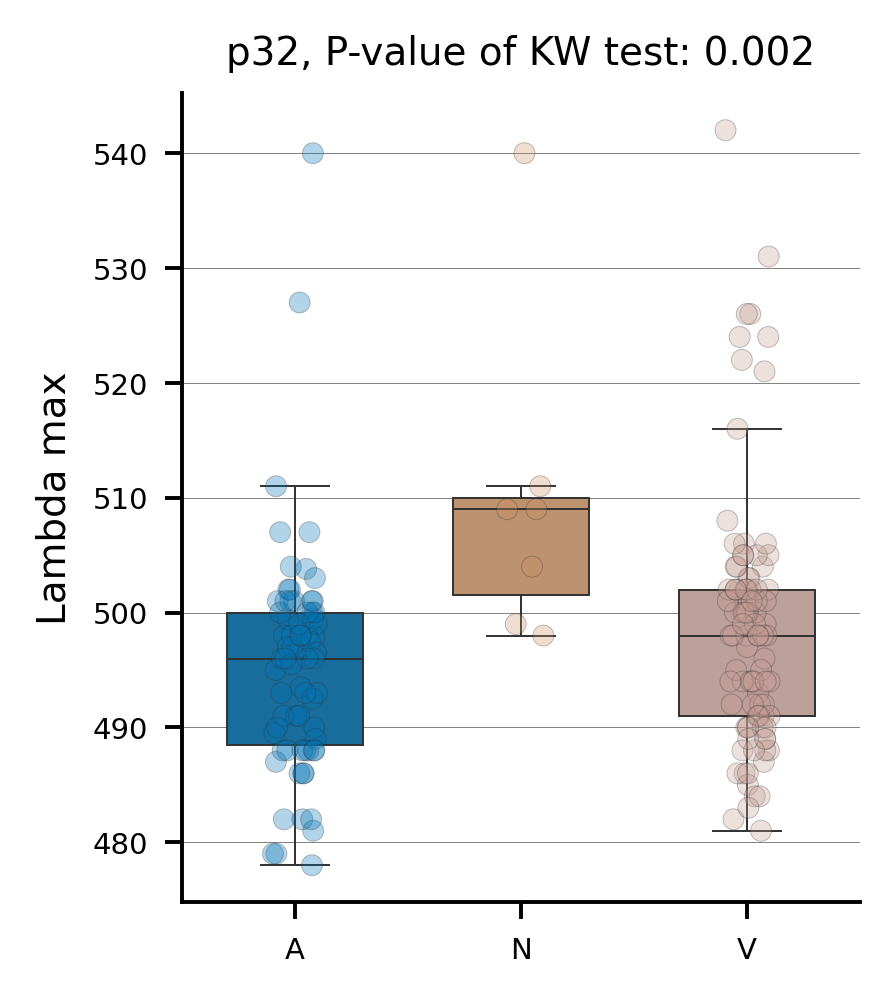

In [23]:
pl = plot_imp_all(final_models=top,
                  X_train=tr, y_train=y,
                  aggregate_function='max',
                  meta_var='Lambda max',
                  model_type = ana_type,
                  report_dir=report_dir, max_plots=100,
                  figsize=(2.5, 3))

In [24]:
# printing important positions with their importance values
positions = list(mean_imp.sort_values('mean', ascending=False)['feature'][:100])
importance = list(mean_imp.sort_values('mean', ascending=False)['mean'][:100].round(3))

ref_compare = None
ref_id = -1
compare_len = 30
imp_print(raw_seq, position=positions, importance=importance,
          ref_seq_id=ref_id, compare_with=ref_compare,
          compare_len=compare_len, report_dir=report_dir)

In [25]:
from deepBreaks.utils import load_obj
load_model = load_obj(report_dir + '/rf.pkl')

In [26]:
load_model

Pipeline(steps=[('prep',
                 Pipeline(steps=[('mc', MisCare(missing_threshold=0.05)),
                                 ('cc', ConstantCare()),
                                 ('ur', URareCare(threshold=0.025)),
                                 ('cc2', ConstantCare()),
                                 ('one_hot', CustomOneHotEncoder()),
                                 ('st_sc', CustomStandardScaler()),
                                 ('feature_selection',
                                  FeatureSelection(alpha=0.25, keep=True,
                                                   model_type='reg')),
                                 ('collinear_care',
                                  CollinearCare(dist_method='correlation',
                                                keep=True, threshold=0.25))])),
                ('rf',
                 RandomForestRegressor(max_features='sqrt', n_jobs=-1,
                                       random_state=123))])